# Analysis of an online retail data set

_https://archive.ics.uci.edu/ml/datasets/Online+Retail_
___

## Task 0.1 - set up the Python environment

In [91]:
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import missingno as msno
from sklearn import metrics
from sklearn.preprocessing import scale, StandardScaler, normalize
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import pickle
from collections import Counter

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.1f}'.format

%matplotlib inline

## task 1 - data analysis

### Data import and cleaning

In [92]:
data = pd.read_csv('./data.csv',encoding='ISO-8859-1')

In [93]:
data.shape

(541909, 8)

The data consists of 8 columns and 541909 rows.

In [94]:
data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.5,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.4,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.8,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.4,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.4,17850.0,United Kingdom


A cursory check for missing data:

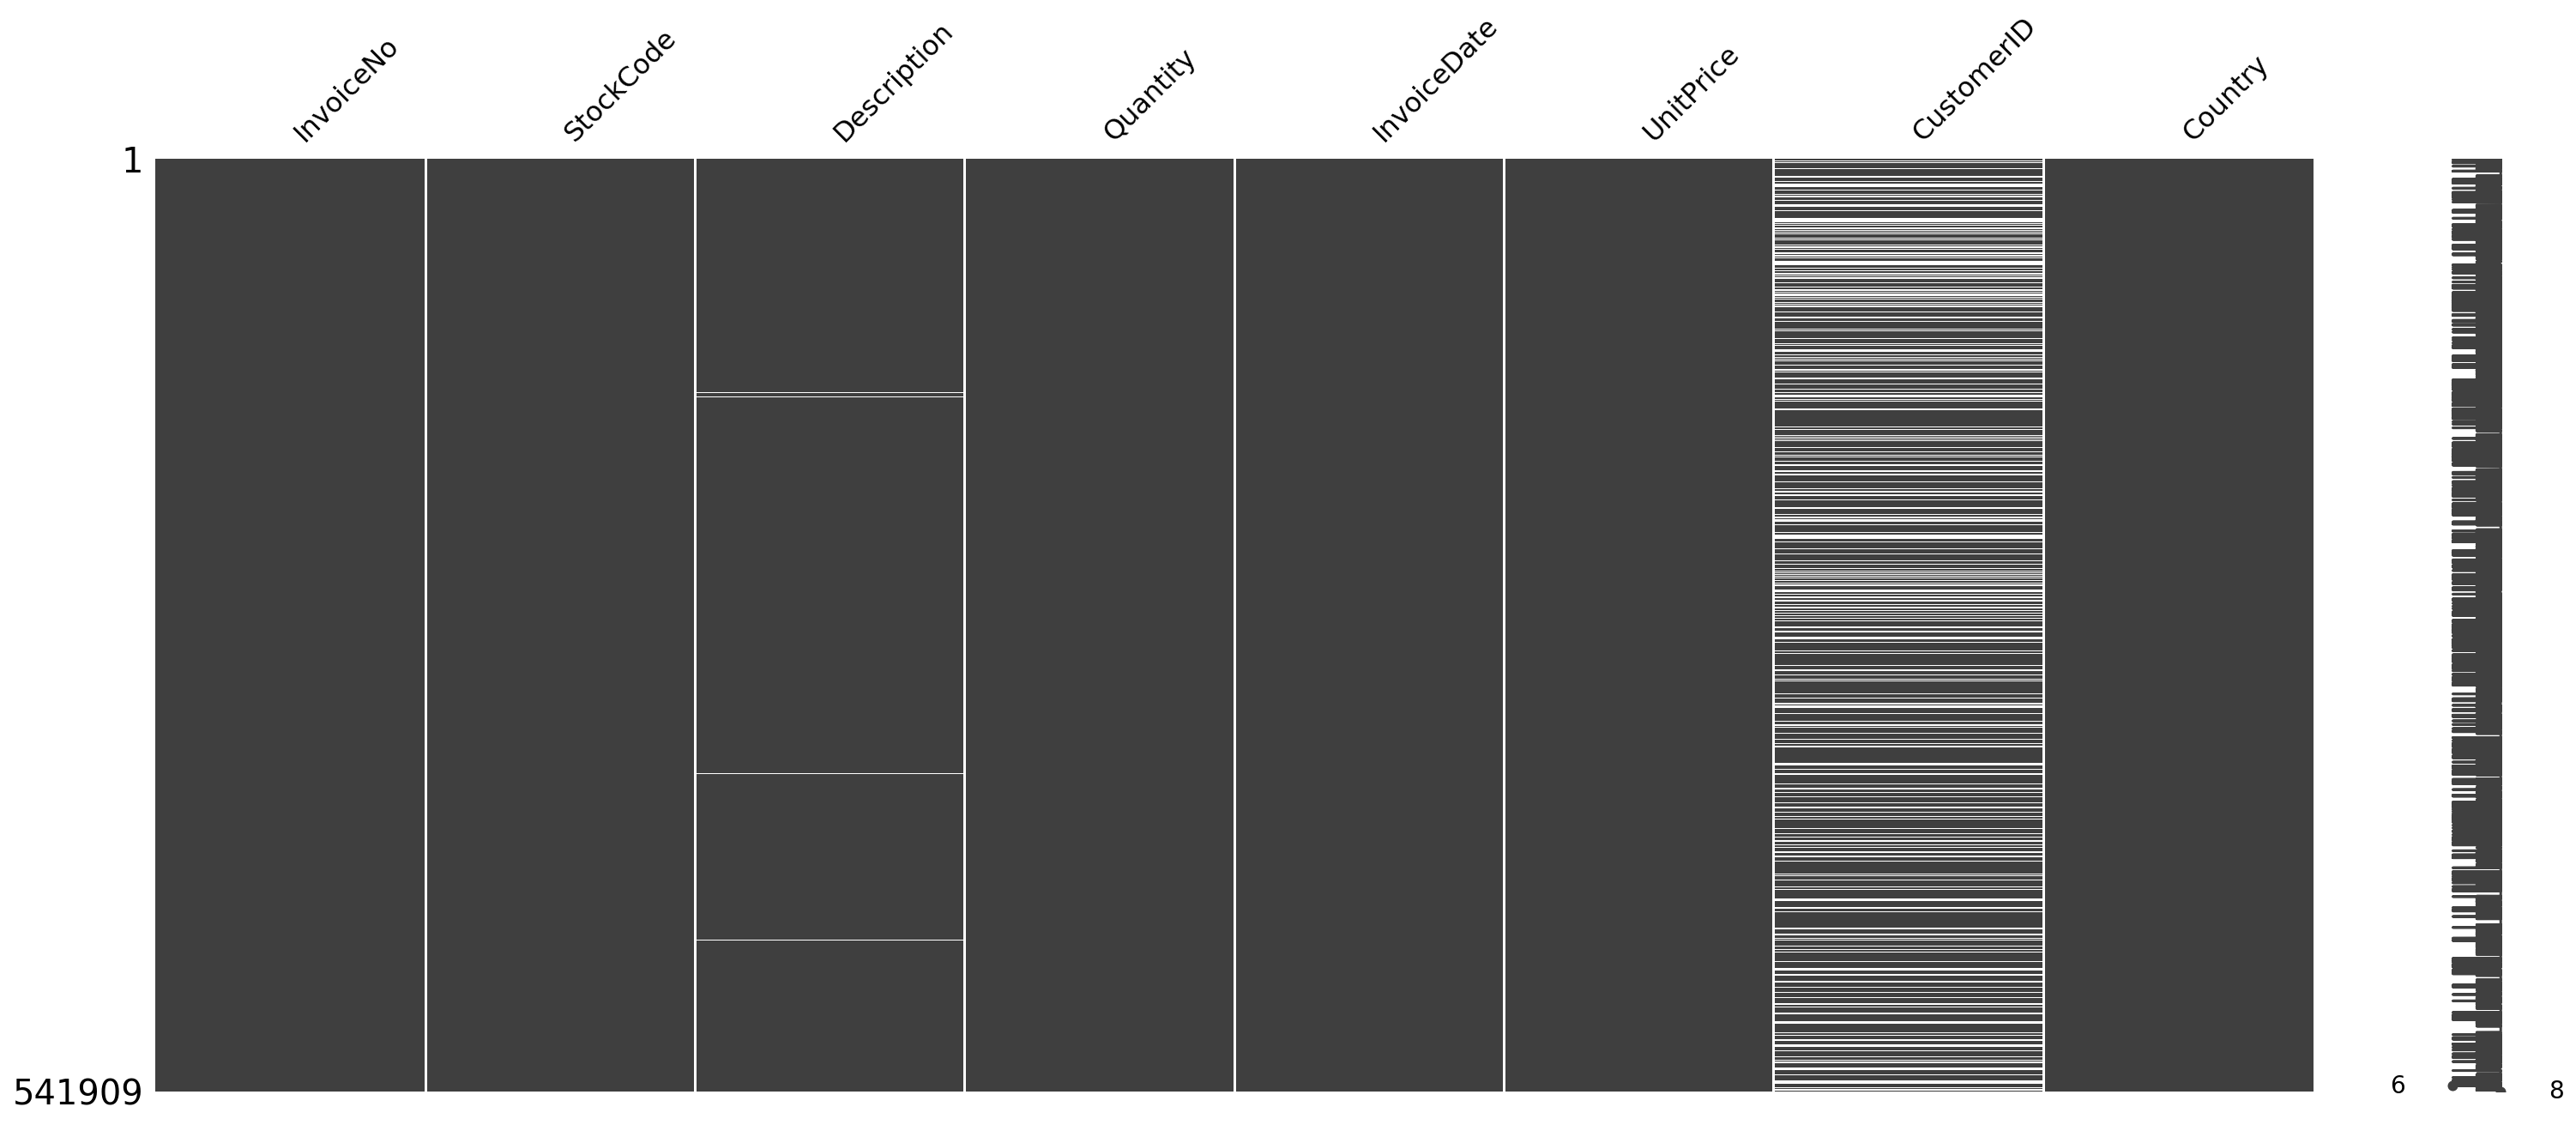

In [95]:
msno.matrix(data);

The dataset is missing some Description and customer ID data entries.

In [96]:
null_data = data[data.isnull().any(axis=1)]
null_data.shape

(135080, 8)

In [97]:
null_data_frac = null_data.shape[0]/data.shape[0]*100
null_data_frac

24.926694334288598

25% of the data contains missing values, which the figure above indicates is mostly nan values in CustomerID

## Exploratory data analysis

In [98]:
data = data.sort_values('Quantity', ascending=False)
data.head(11)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.1,16446.0,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.0,12346.0,United Kingdom
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,11/25/2011 15:57,0.0,13256.0,United Kingdom
74614,542504,37413,NaN,5568,1/28/2011 12:03,0.0,nan,United Kingdom
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,10/27/2011 12:26,0.2,12901.0,United Kingdom
206121,554868,22197,SMALL POPCORN HOLDER,4300,5/27/2011 10:52,0.7,13135.0,United Kingdom
220843,556231,85123A,?,4000,6/9/2011 15:04,0.0,nan,United Kingdom
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2/22/2011 10:43,0.8,18087.0,United Kingdom
270885,560599,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,3186,7/19/2011 17:04,0.1,14609.0,United Kingdom
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,4/18/2011 13:20,2.1,15749.0,United Kingdom


The top 10 most popular items are sold in/to the UK. Apparently paper craft little birdie is very popular, along with medium ceramic top storage jar. I will remove the items with 'NaN' descriptor. These entries associated with nan CustomerID entries and 131 lower case descriptions which describe problems with the orders and no details of the item ordered. In addition, the data for United Kingdom contains negative values associated with negative UnitPrice values. Removing the rows containing NaN values therefore cleans several issues that complicate this analysis in the absence of the data owner.

In [99]:
data = data.dropna()

In [100]:
data.shape # 541909 - 406829 = dropped 135,080 entries

(406829, 8)

In [101]:
# in addition I will check for duplicate entries and remove those
data.drop_duplicates(inplace = True)

In [102]:
data.shape

(401604, 8)

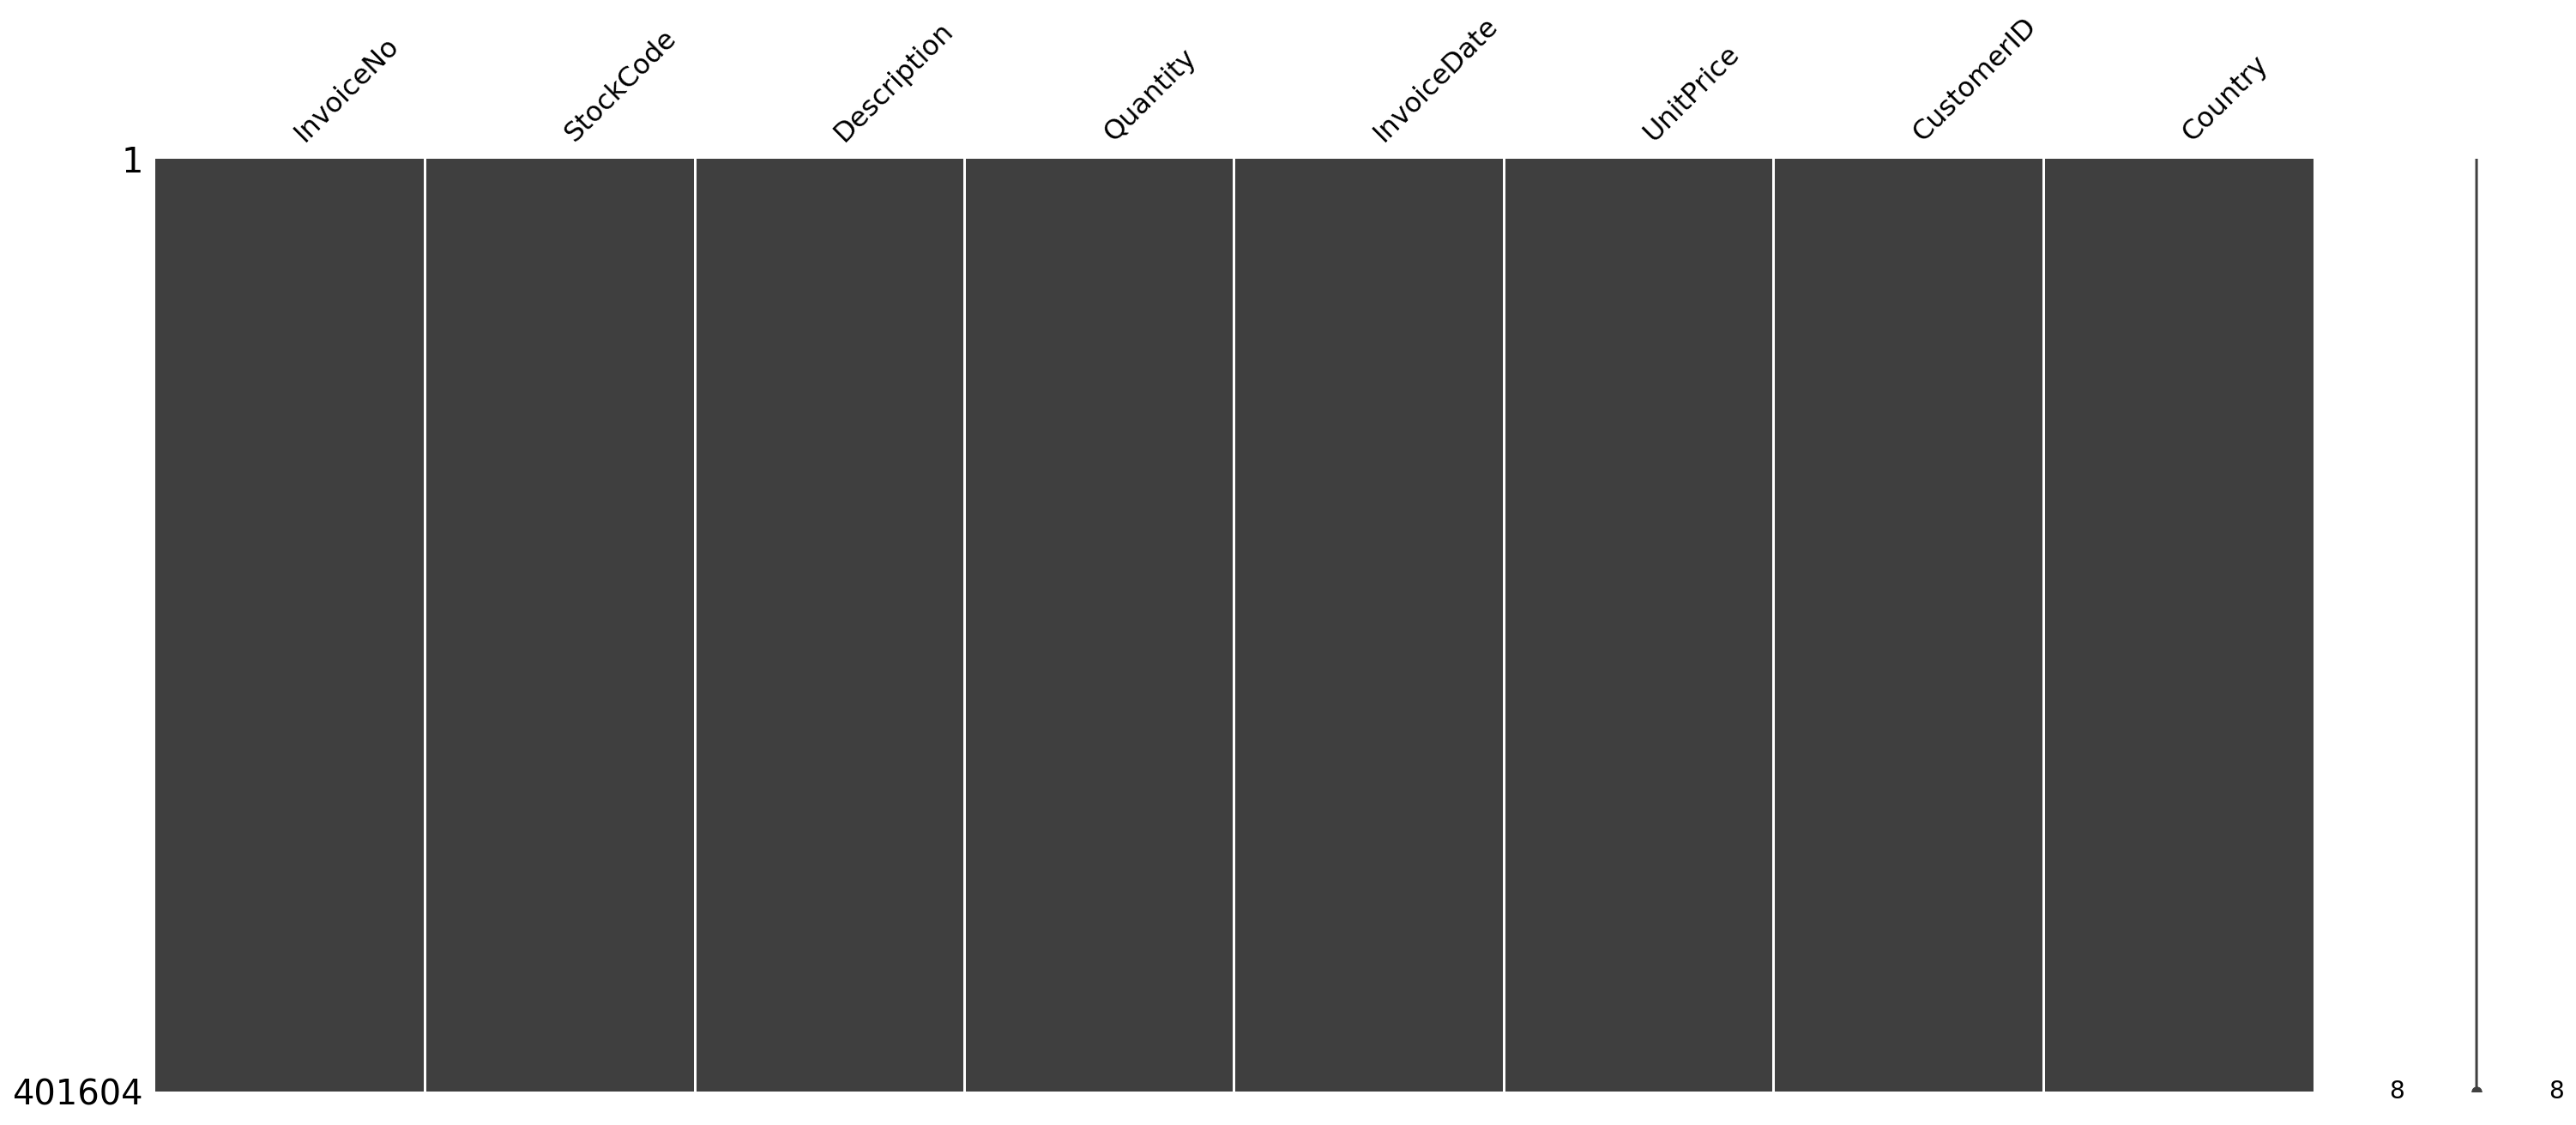

In [103]:
msno.matrix(data);

We now have no missing values and have removed assumed erroneous results and duplicates.

## Task 2 - Further exploration and trend analysis

How many unique descriptors are there in "Descriptions"?

In [104]:
# general clean up of Description column to remove any heading or trailing white space
data['Description'] = data['Description'].str.strip()
descriptors = pd.unique(data['Description'].values.ravel()).tolist()
print('There are',len(descriptors), 'unique descriptors in the Descriptions column.')

There are 3885 unique descriptors in the Descriptions column.


In [105]:
descriptors2 = []
for i in range(0,len(descriptors),1):
    text = str(descriptors[i])
    if text == text.upper():
        descriptors2.append(text)
        
print('There are', len(descriptors2), 'all caps descriptors.')

There are 3862 all caps descriptors.


In [106]:
# from inspection of the baskets below I identified 3 problem descriptors that need to be followed up.
additional_problem_list = ['damages/credits from ASOS.','incorrectly credited C550456 see 47', 'mystery! Only ever imported 1800']

In [107]:
# remove additional erroneous rows
data = data[~data['Description'].isin(additional_problem_list)]

In [108]:
data.shape

(401604, 8)

In [109]:
InvoiceNo = pd.unique(data['InvoiceNo'].values.ravel()).tolist()
print('There are', len(InvoiceNo), 'unique invoice numbers in the dataset.')

There are 22190 unique invoice numbers in the dataset.


### Group by country

In [110]:
by_country = data.groupby('Country')
by_country.describe()

CustomerID                                         \
                          count    mean    std     min     25%     50%   
Country                                                                  
Australia                1258.0 12464.7  438.0 12386.0 12415.0 12415.0   
Austria                   401.0 12521.5  216.5 12358.0 12360.0 12374.0   
Bahrain                    17.0 12354.5    0.9 12353.0 12355.0 12355.0   
Belgium                  2069.0 12430.3  110.0 12361.0 12383.0 12407.0   
Brazil                     32.0 12769.0    0.0 12769.0 12769.0 12769.0   
Canada                    151.0 17321.1  521.5 15388.0 17444.0 17444.0   
Channel Islands           757.0 14888.1  142.8 14442.0 14930.0 14936.0   
Cyprus                    611.0 12405.4  200.6 12359.0 12359.0 12370.0   
Czech Republic             30.0 12781.0    0.0 12781.0 12781.0 12781.0   
Denmark                   389.0 12536.6  421.9 12367.0 12406.0 12412.0   
EIRE                     7475.0 14748.7  314.5 14016.0 14911.0 14911.0   
European Community         61.0 15108.0    0.0 15108.0 15108.0 15108.0   
Finland                   695.0 12517.0  122.4 12348.0 12428.0 12428.0   
France                   8475.0 12677.5  275.4 12413.0 12571.0 12674.0   
Germany                  9480.0 12645.8  307.9 12426.0 12480.0 12592.0   
Greece                    146.0 13757.4 1749.6 12478.0 12717.0 12717.0   
Iceland                   182.0 12347.0    0.0 12347.0 12347.0 12347.0   
Israel                    247.0 12659.6   57.6 12512.0 12653.0 12688.0   
Italy                     803.0 12648.4  437.4 12349.0 12578.0 12584.0   
Japan                     358.0 12757.8   13.6 12753.0 12753.0 12753.0   
Lebanon                    45.0 12764.0    0.0 12764.0 12764.0 12764.0   
Lithuania                  35.0 15332.0    0.0 15332.0 15332.0 15332.0   
Malta                     127.0 16996.0 1127.5 15480.0 15480.0 17828.0   
Netherlands              2371.0 14420.3  609.5 12759.0 14646.0 14646.0   
Norway                   1086.0 12438.0   76.7 12350.0 12432.0 12433.0   
Poland                    341.0 12733.1   94.9 12576.0 12576.0 12779.0   
Portugal                 1471.0 12746.4   97.3 12356.0 12757.0 12766.0   
RSA                        58.0 12446.0    0.0 12446.0 12446.0 12446.0   
Saudi Arabia               10.0 12565.0    0.0 12565.0 12565.0 12565.0   
Singapore                 229.0 12744.0    0.0 12744.0 12744.0 12744.0   
Spain                    2528.0 12906.1 1272.4 12354.0 12484.0 12540.0   
Sweden                    461.0 14701.4 2379.8 12483.0 12638.0 12697.0   
Switzerland              1877.0 12667.0  460.8 12357.0 12378.0 12451.0   
USA                       291.0 12618.9   38.5 12558.0 12607.0 12607.0   
United Arab Emirates       68.0 14984.6 2546.1 12739.0 12739.0 12739.0   
United Kingdom         356728.0 15543.8 1594.3 12346.0 14191.0 15513.0   
Unspecified               241.0 13733.7 1520.9 12363.0 12743.0 12743.0   

                                     Quantity                                 \
                         75%     max    count mean   std      min   25%  50%   
Country                                                                        
Australia            12415.0 16321.0   1258.0 66.5  97.7   -120.0   6.0 24.0   
Austria              12818.0 12865.0    401.0 12.0  21.7    -48.0   6.0  9.0   
Bahrain              12355.0 12355.0     17.0 15.3  25.0      2.0   6.0  6.0   
Belgium              12431.0 12876.0   2069.0 11.2  13.6    -12.0   4.0 10.0   
Brazil               12769.0 12769.0     32.0 11.1   8.5      2.0   3.0 10.0   
Canada               17444.0 17844.0    151.0 18.3  46.7      1.0   6.0 12.0   
Channel Islands      14936.0 14937.0    757.0 12.5  22.6     -2.0   4.0 10.0   
Cyprus               12391.0 13809.0    611.0 10.3  23.4    -33.0   2.0  5.0   
Czech Republic       12781.0 12781.0     30.0 19.7  22.8    -24.0  12.0 24.0   
Denmark              12429.0 13919.0    389.0 21.0  27.4    -25.0  12.0 12.0   
EIRE                

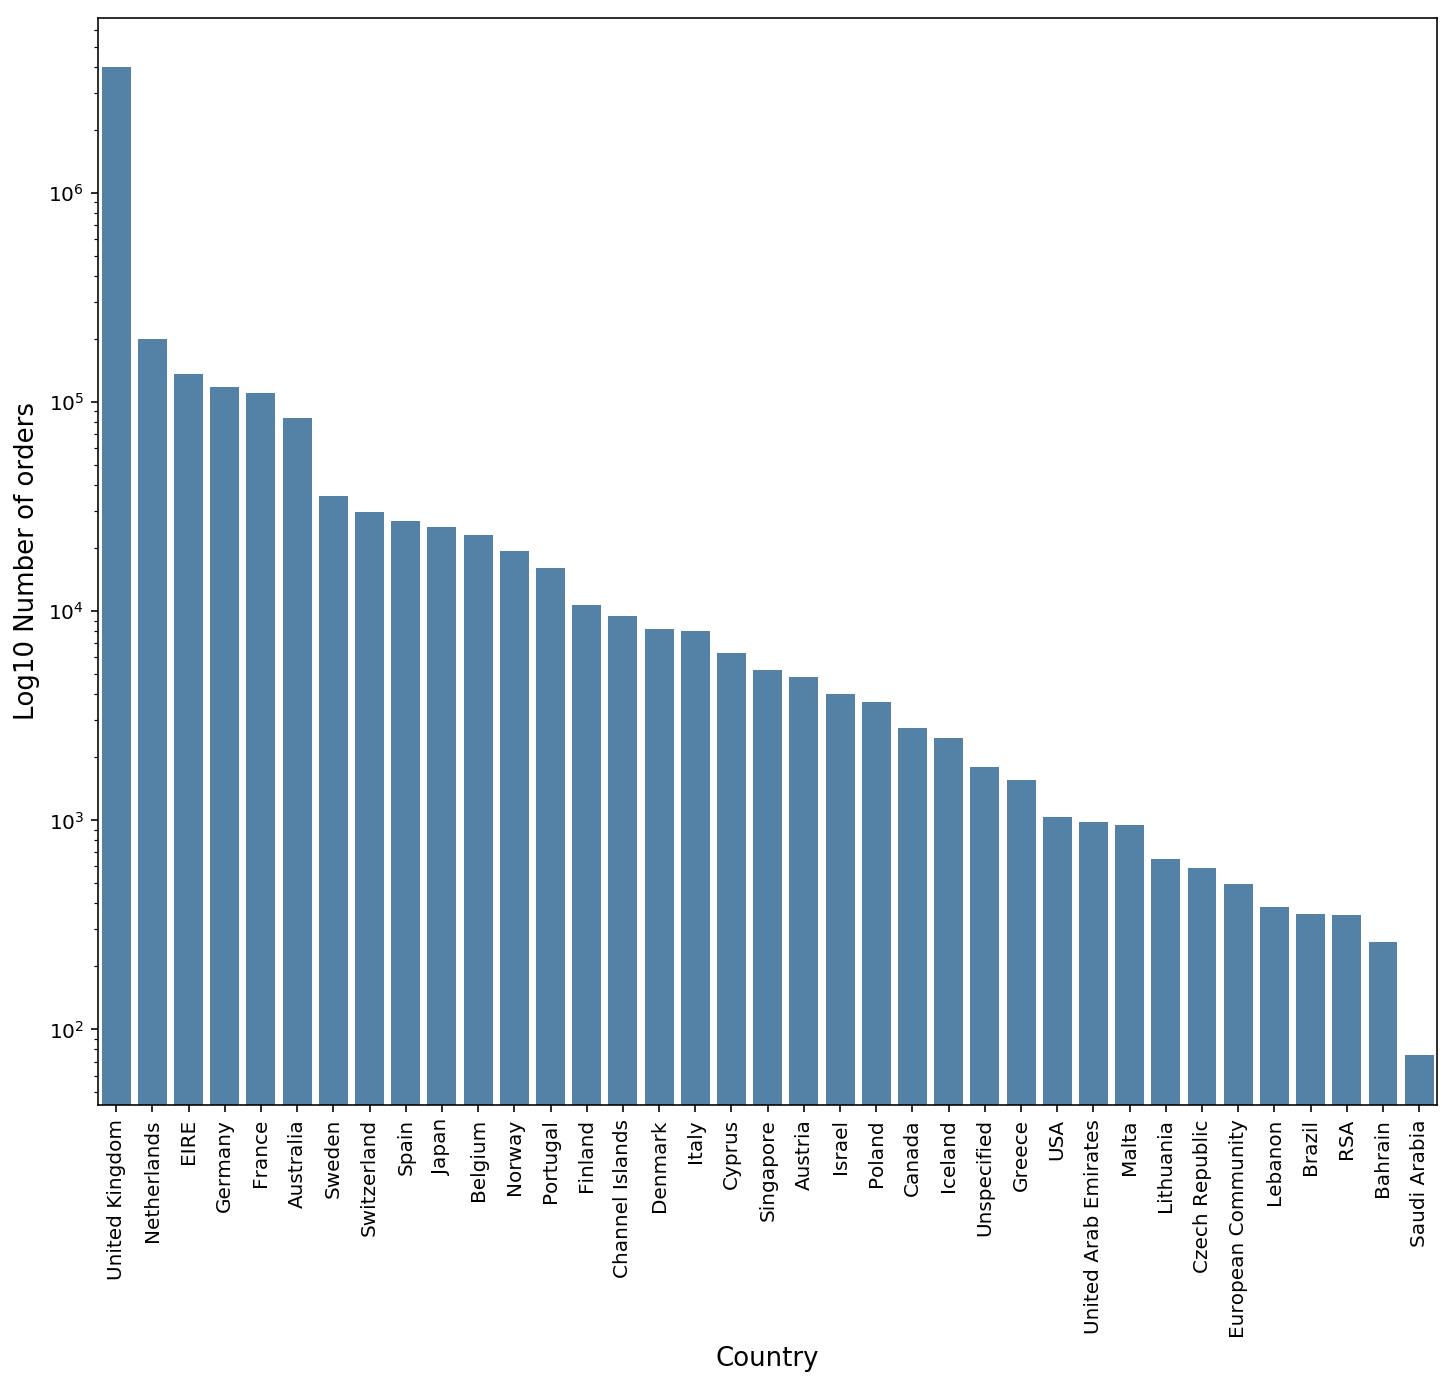

In [111]:
grouped  = data.groupby(['Country']).sum()['Quantity'].sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values, color='steelblue')
f.get_axes()[0].set_yscale('log') #I'm using a log scale just for visualisation as the UK dominates the market
plt.ylabel('Log10 Number of orders', fontsize=13)
plt.xlabel('Country', fontsize=13)
plt.show()

The United Kingdom purchases the majority of products by almost 2 orders of magnitude.

In [112]:
# group by customer ID and invoice number to create a basket per customer
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
products_per_basket[:10].sort_values('Number of products', ascending=False)

,CustomerID,InvoiceNo,Number of products
7,12347.0,573511,47
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
6,12347.0,562032,22
5,12347.0,556201,18
9,12348.0,539318,17
8,12347.0,581180,11
0,12346.0,541431,1
1,12346.0,C541433,1


There are InvoiceNo entries beginning with the character C.

In [113]:
print('There are:',data['InvoiceNo'].str.contains("C").sum(), 'orders marked C, which contribute',(data['InvoiceNo'].str.contains("C").sum()/len(data))*100, '% of the dataset.')

There are: 8872 orders marked C, which contribute 2.209141343213713 % of the dataset.


In [114]:
# select all the cancelled orders
cancelled_orders = data[data.InvoiceNo.str.contains("C")]
cancelled_orders.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
268308,C560408,M,Manual,-1,7/18/2011 14:24,550.6,13564.0,United Kingdom
186013,C552841,22838,3 TIER CAKE TIN RED AND CREAM,-1,5/11/2011 14:28,14.9,15827.0,United Kingdom
169480,C551175,22325,MOBILE VINTAGE HEARTS,-1,4/26/2011 17:17,5.0,14329.0,United Kingdom
429996,C573575,CRUK,CRUK Commission,-1,10/31/2011 14:09,606.0,14096.0,United Kingdom
281674,C561591,22768,FAMILY PHOTO FRAME CORNICE,-1,7/28/2011 11:17,9.9,15708.0,United Kingdom
268312,C560409,84078A,SET/4 WHITE RETRO STORAGE CUBES,-1,7/18/2011 14:24,40.0,16717.0,United Kingdom
355585,C567947,23234,BISCUIT TIN VINTAGE CHRISTMAS,-1,9/23/2011 8:00,2.9,17663.0,United Kingdom
355584,C567947,21201,TROPICAL HONEYCOMB PAPER GARLAND,-1,9/23/2011 8:00,2.5,17663.0,United Kingdom
96677,C544577,M,Manual,-1,2/21/2011 14:02,320.7,12365.0,Cyprus
45144,C540250,21928,JUMBO BAG SCANDINAVIAN PAISLEY,-1,1/5/2011 16:02,1.6,17511.0,United Kingdom


InvoiceNo containing a "C" character correspond with a negative Quantity value, therefore I will assume these are cancelled orders. For the purposes of this report I am going to remove cancelled orders from consideration.

In [115]:
data = data[~data['InvoiceNo'].str.contains("C")]

In [116]:
# group by customer ID to create a rank buyers by how many products they buy in total.
temp = data.groupby(by=['CustomerID'], as_index=False)['InvoiceDate'].count()
products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
top_baskets = products_per_basket.sort_values('Number of products', ascending=False)
top_baskets.head(10)

,CustomerID,Number of products
4011,17841.0,7676
1880,14911.0,5672
1290,14096.0,5111
326,12748.0,4413
1662,14606.0,2677
2177,15311.0,2366
1690,14646.0,2080
562,13089.0,1814
691,13263.0,1667
1435,14298.0,1637


/Users/scheckley/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


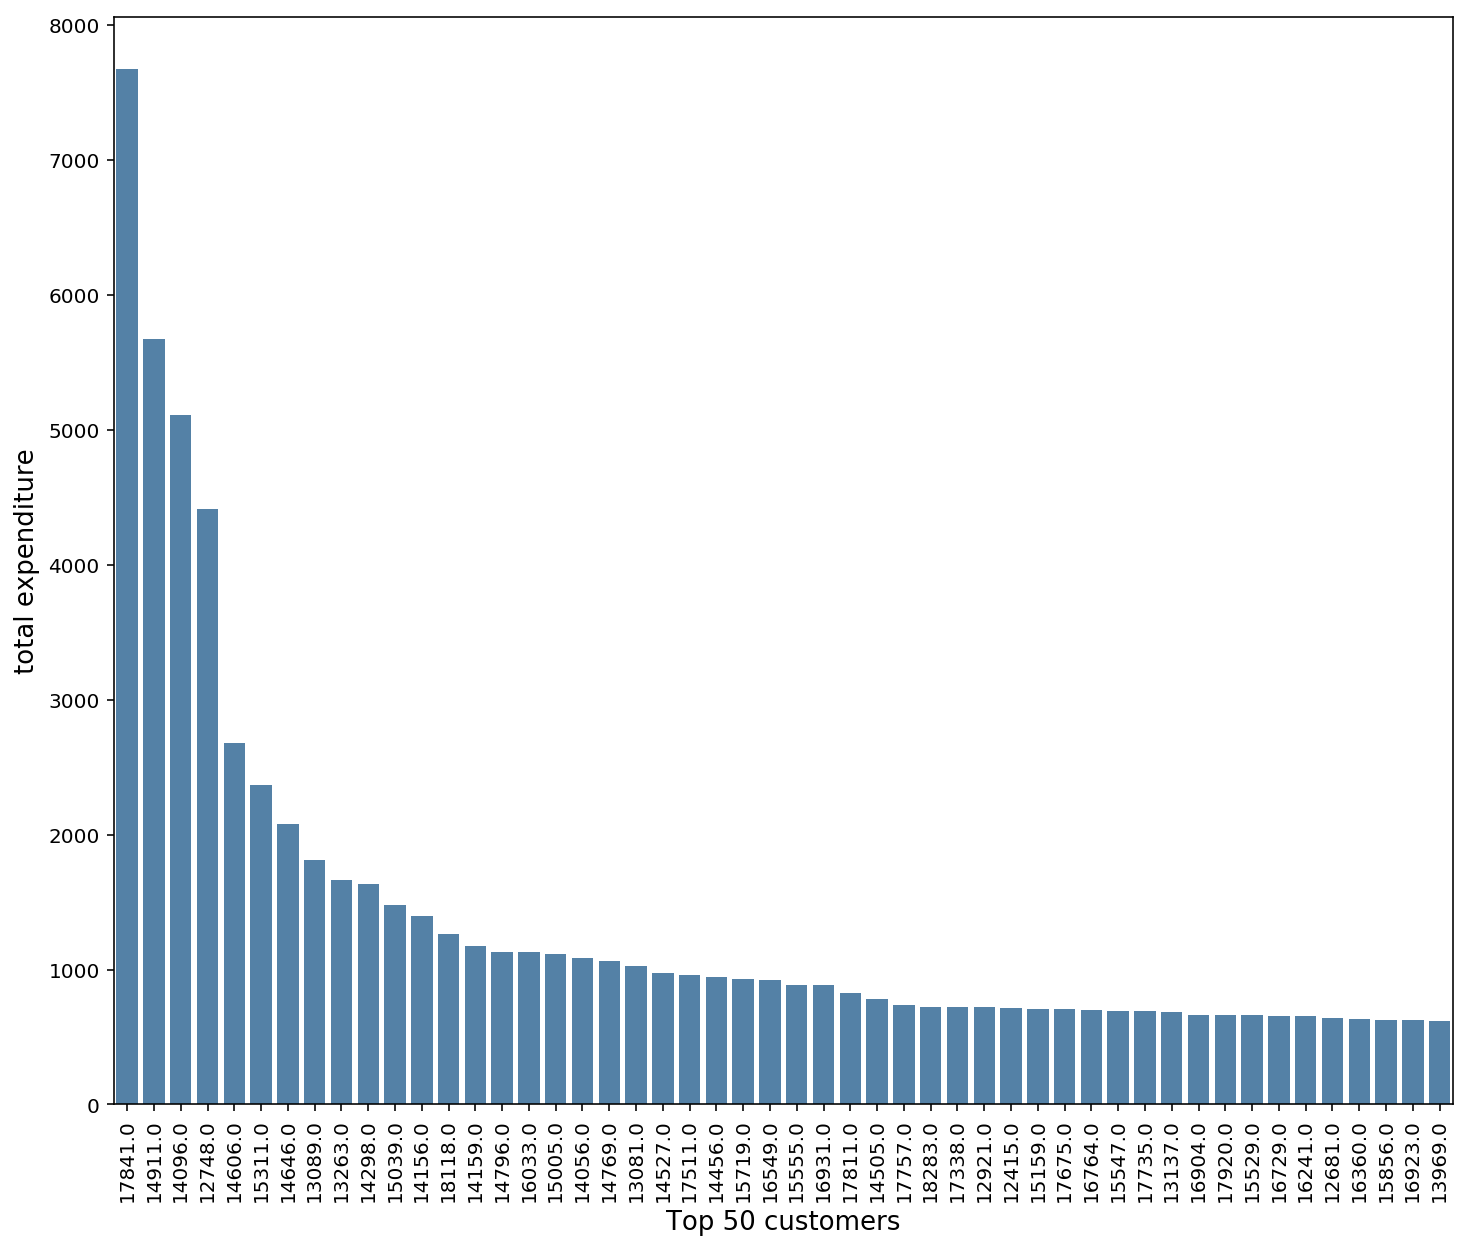

In [117]:
grouped = top_baskets[:50]
grouped.reset_index(level=0, inplace=True)
grouped.sort_values('Number of products', ascending=False, inplace=True)

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(x=grouped['CustomerID'], y=grouped['Number of products'],order=grouped['CustomerID'],color='steelblue',ci=None)
plt.ylabel('total expenditure', fontsize=13)
plt.xlabel('Top 50 customers', fontsize=13)
plt.show()

### Investigation of which items are contained in the top CustomerID basket

In [118]:
top_basket = data[data['CustomerID'] == top_baskets['CustomerID'].iloc[0]]
#top_basket #uncomment to view basket contents

_Note - this investigation was used with apriori modeling detailed in the Addendum section._

### Investigation of StockCode

There are some non-integer values in StockCodes which correspond with order descriptions that are not items.

In [119]:
mask = (~data['StockCode'].str.contains('[0-9]'))
odd_stock_codes = data.loc[mask] #filter out any stock codes that are numeric to leave the non-standard codes
odd_stock_codes.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
490502,578060,M,Manual,1600,11/22/2011 15:22,0.2,17857.0,United Kingdom
452218,575328,M,Manual,1200,11/9/2011 13:48,0.2,17857.0,United Kingdom
437235,574277,M,Manual,832,11/3/2011 14:42,0.2,17857.0,United Kingdom
526018,580646,M,Manual,800,12/5/2011 13:13,0.2,17857.0,United Kingdom
414138,572344,M,Manual,456,10/24/2011 10:43,1.5,14607.0,United Kingdom


In [120]:
odd_stock_codes['StockCode'].unique(), print('total number of these short stock code entries:',len(odd_stock_codes))

total number of these short stock code entries: 1416


(array(['M', 'POST', 'DOT', 'BANK CHARGES', 'PADS'], dtype=object), None)

As the number of non-standard stock codes is small, for the purposes of this report they will be deleted from the dataset.

In [121]:
data = data.loc[~mask]

During the data cleaning process NaN, duplicate entries, cancelled invoices, and miscellaneous stock codes have been removed.

## Investigation of Invoice Date

In [122]:
timestamp_list = list(data.InvoiceDate)

Timeframe = pd.DataFrame(pd.to_datetime(timestamp_list), columns=['time'])

In [123]:
data['time'] = Timeframe['time'].values

In [124]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,time
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.1,16446.0,United Kingdom,2011-12-09 09:15:00
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.0,12346.0,United Kingdom,2011-01-18 10:01:00
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,11/25/2011 15:57,0.0,13256.0,United Kingdom,2011-11-25 15:57:00
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,10/27/2011 12:26,0.2,12901.0,United Kingdom,2011-10-27 12:26:00
206121,554868,22197,SMALL POPCORN HOLDER,4300,5/27/2011 10:52,0.7,13135.0,United Kingdom,2011-05-27 10:52:00


/Users/scheckley/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  This is separate from the ipykernel package so we can avoid doing imports until


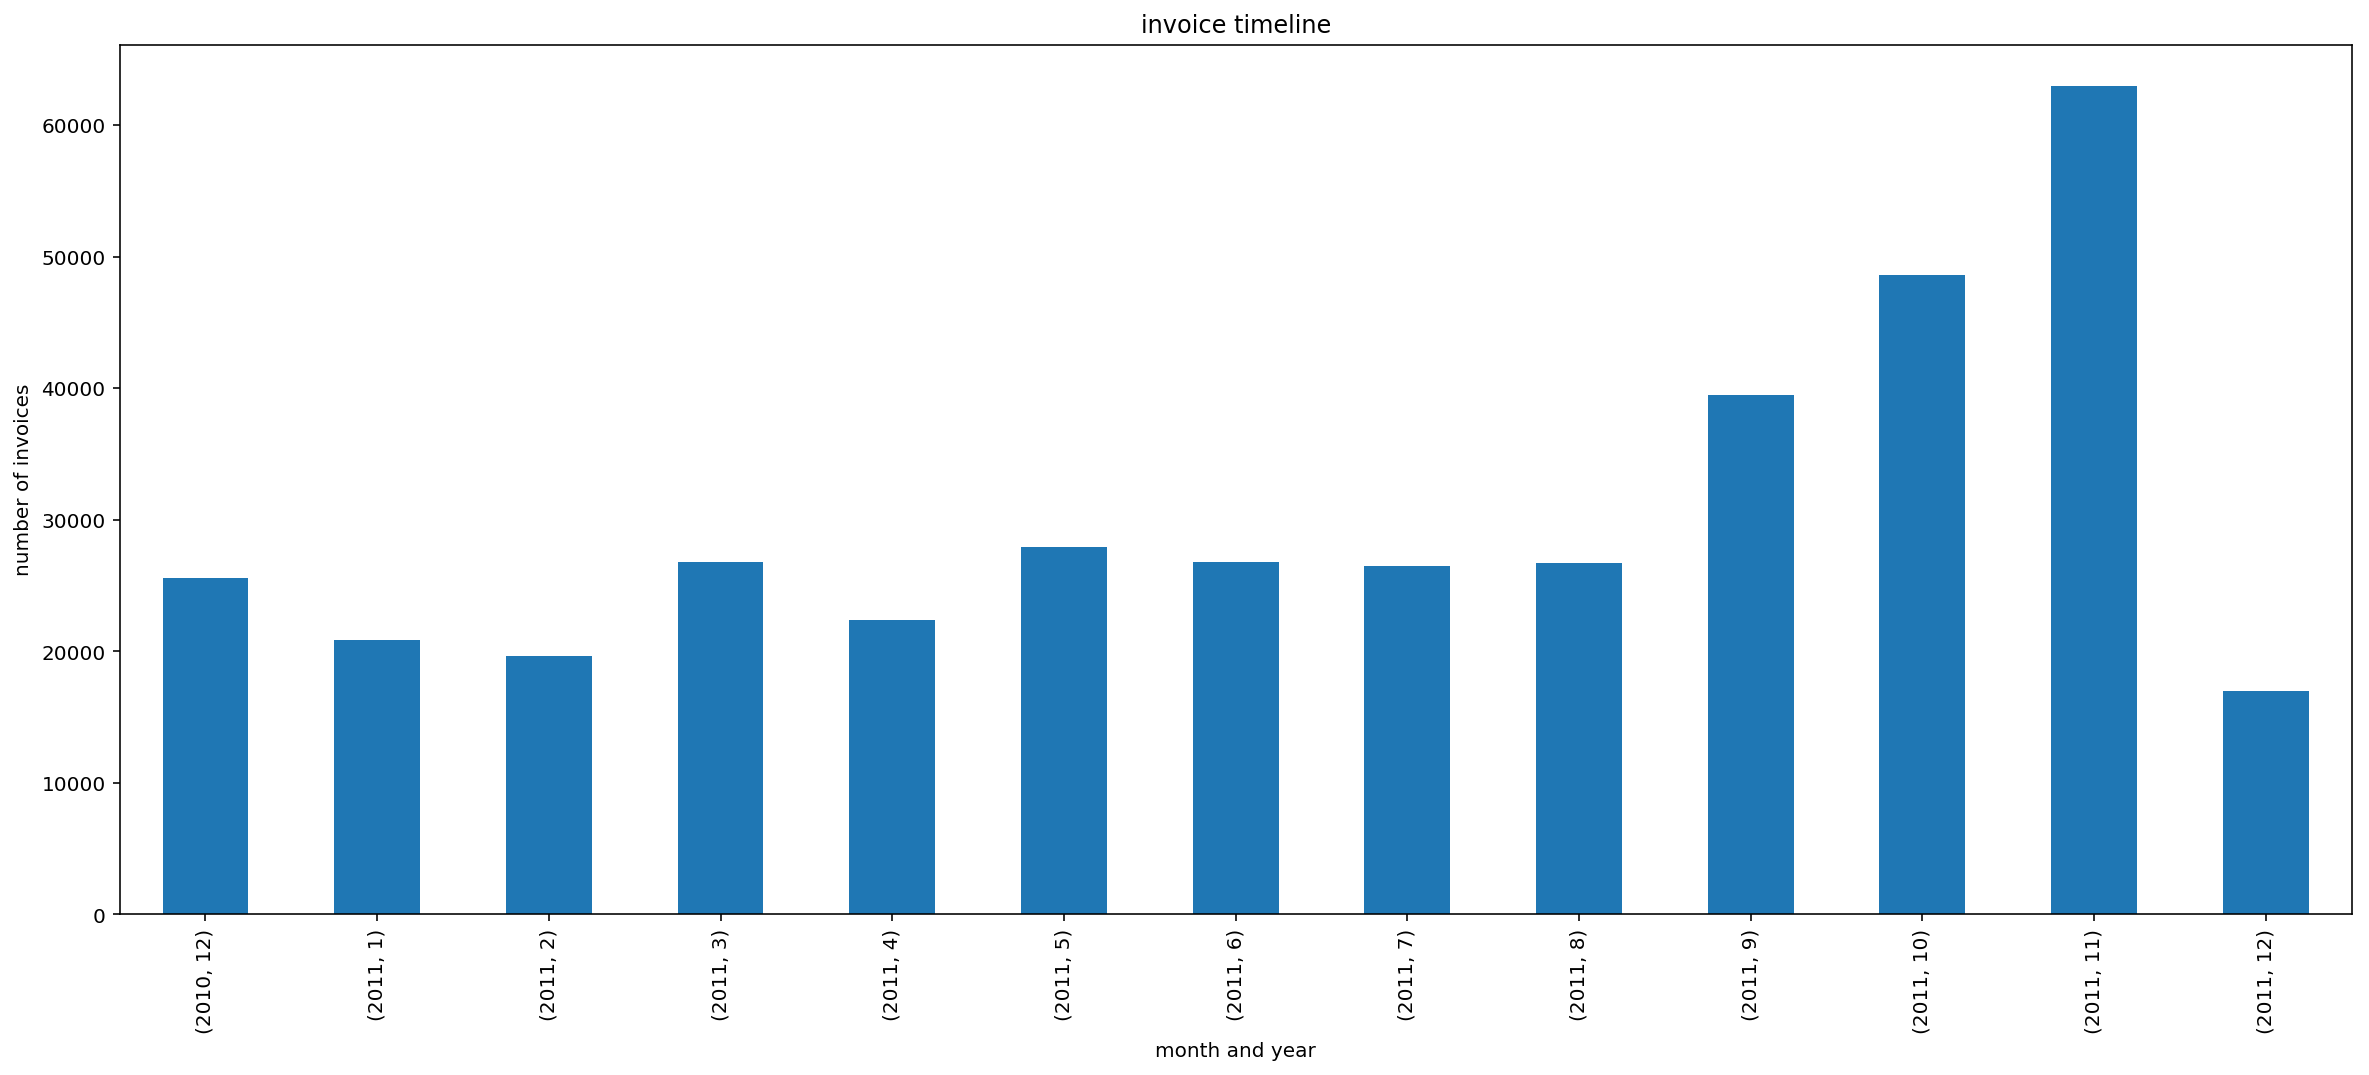

In [125]:
plot_dims = (20, 8)

plot = Timeframe.groupby((Timeframe['time'].dt.year, Timeframe['time'].dt.month.rename('month'))).count().plot(kind="bar",figsize=plot_dims,legend=False)

plot.set(xlabel='month and year', ylabel='number of invoices',title="invoice timeline")
plt.xticks(rotation=90)
plt.show()

Invoice numbers increase in September and October and peak in November, possibly attributed to Christmas shopping.

# Task 3 - Feature engineering

In [126]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,time
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.1,16446.0,United Kingdom,2011-12-09 09:15:00
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.0,12346.0,United Kingdom,2011-01-18 10:01:00
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,11/25/2011 15:57,0.0,13256.0,United Kingdom,2011-11-25 15:57:00
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,10/27/2011 12:26,0.2,12901.0,United Kingdom,2011-10-27 12:26:00
206121,554868,22197,SMALL POPCORN HOLDER,4300,5/27/2011 10:52,0.7,13135.0,United Kingdom,2011-05-27 10:52:00


### Investigating the total amount spent per customers

In [127]:
total_spend = data['Quantity'] * data['UnitPrice']

In [128]:
data = data.assign(total_spend=total_spend.values)

In [129]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,time,total_spend
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.1,16446.0,United Kingdom,2011-12-09 09:15:00,168469.6
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.0,12346.0,United Kingdom,2011-01-18 10:01:00,77183.6
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,11/25/2011 15:57,0.0,13256.0,United Kingdom,2011-11-25 15:57:00,0.0
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,10/27/2011 12:26,0.2,12901.0,United Kingdom,2011-10-27 12:26:00,1008.0
206121,554868,22197,SMALL POPCORN HOLDER,4300,5/27/2011 10:52,0.7,13135.0,United Kingdom,2011-05-27 10:52:00,3096.0


In [130]:
#https://github.com/joaolcorreia/RFM-analysis
#data['time'] = data['time'].dt.strftime('%Y-%m-%d')
#data.rename(columns={'total_spend': 'grand_total'}, inplace=True)
#data.to_csv('data4rfm.csv', sep=',', encoding='utf-8')
#data.head()

### Grouped per country

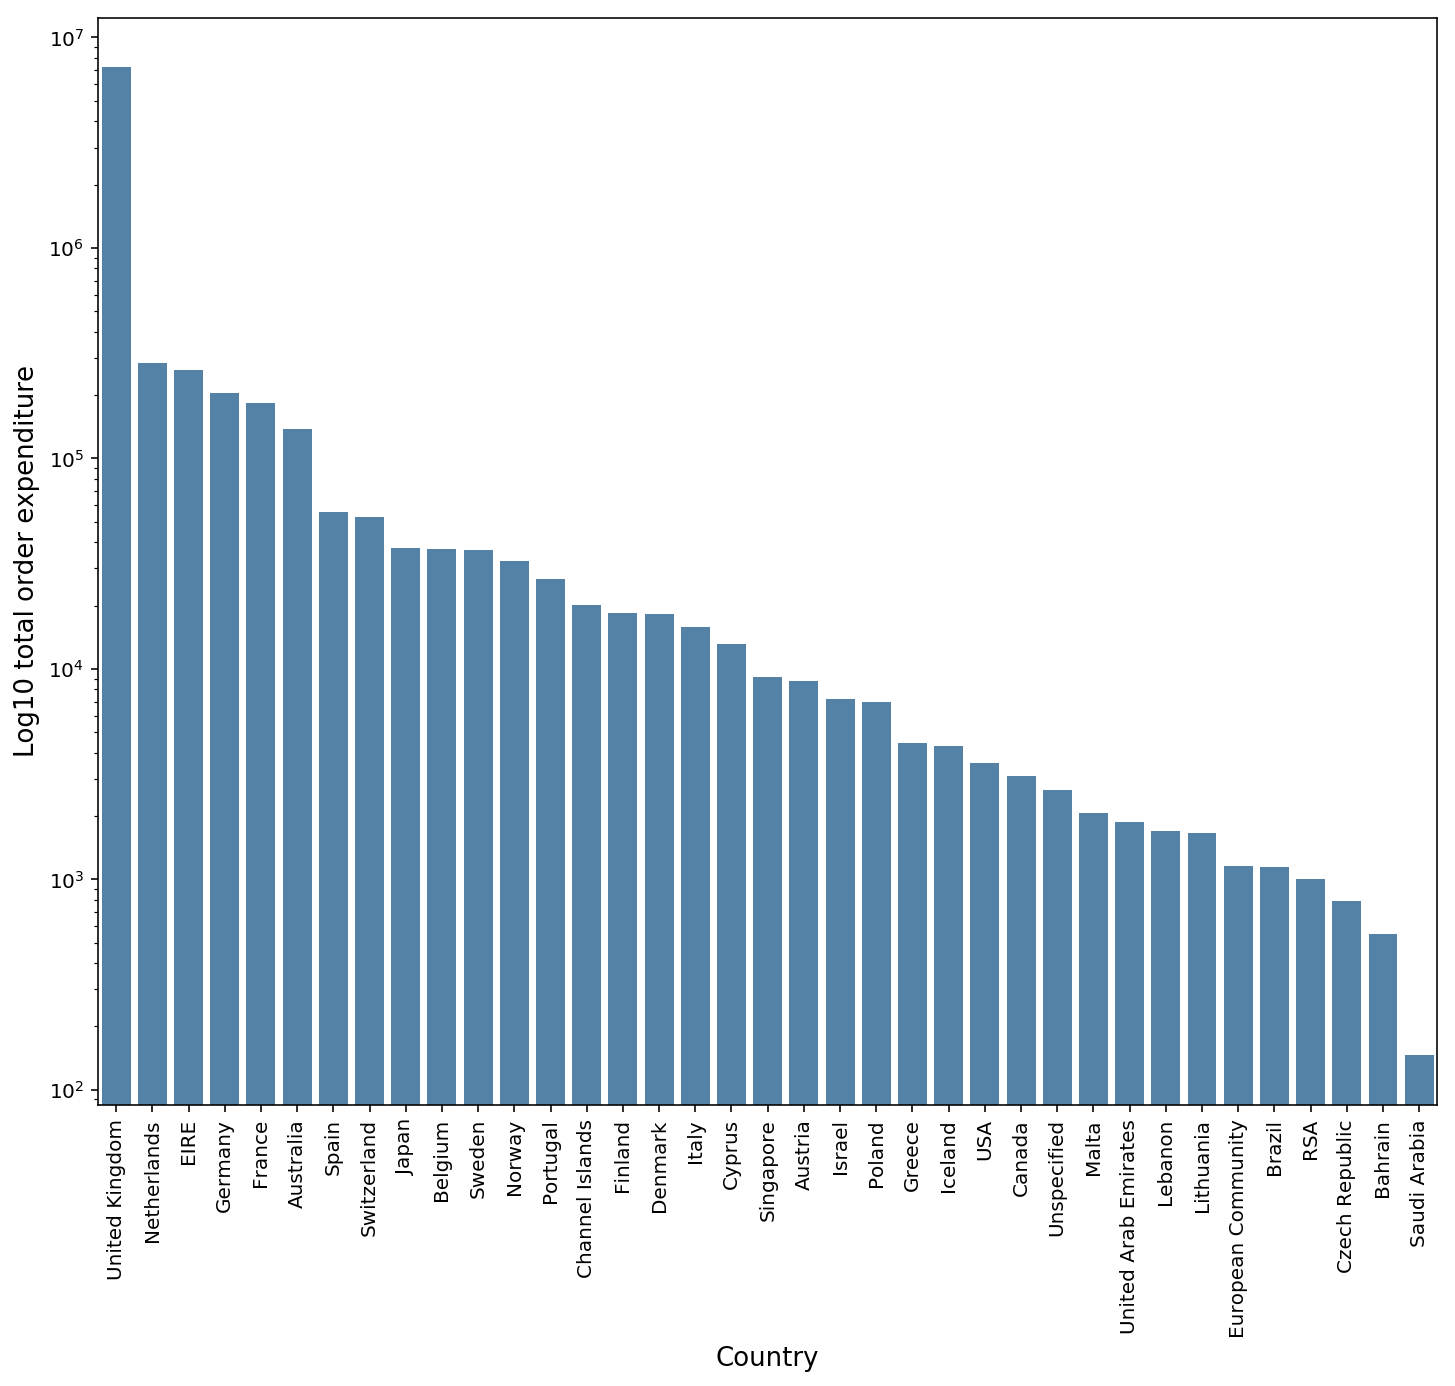

In [131]:
grouped  = data.groupby(['Country']).sum()['total_spend'].sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values, color='steelblue')
f.get_axes()[0].set_yscale('log') #I'm using a log scale just for visualisation as the UK dominates the market
plt.ylabel('Log10 total order expenditure', fontsize=13)
plt.xlabel('Country', fontsize=13)
plt.show()

Customers from the United Kingdom spend the most money in addition to placing the most orders.

### Grouped per customer

* Identify the top purchasers

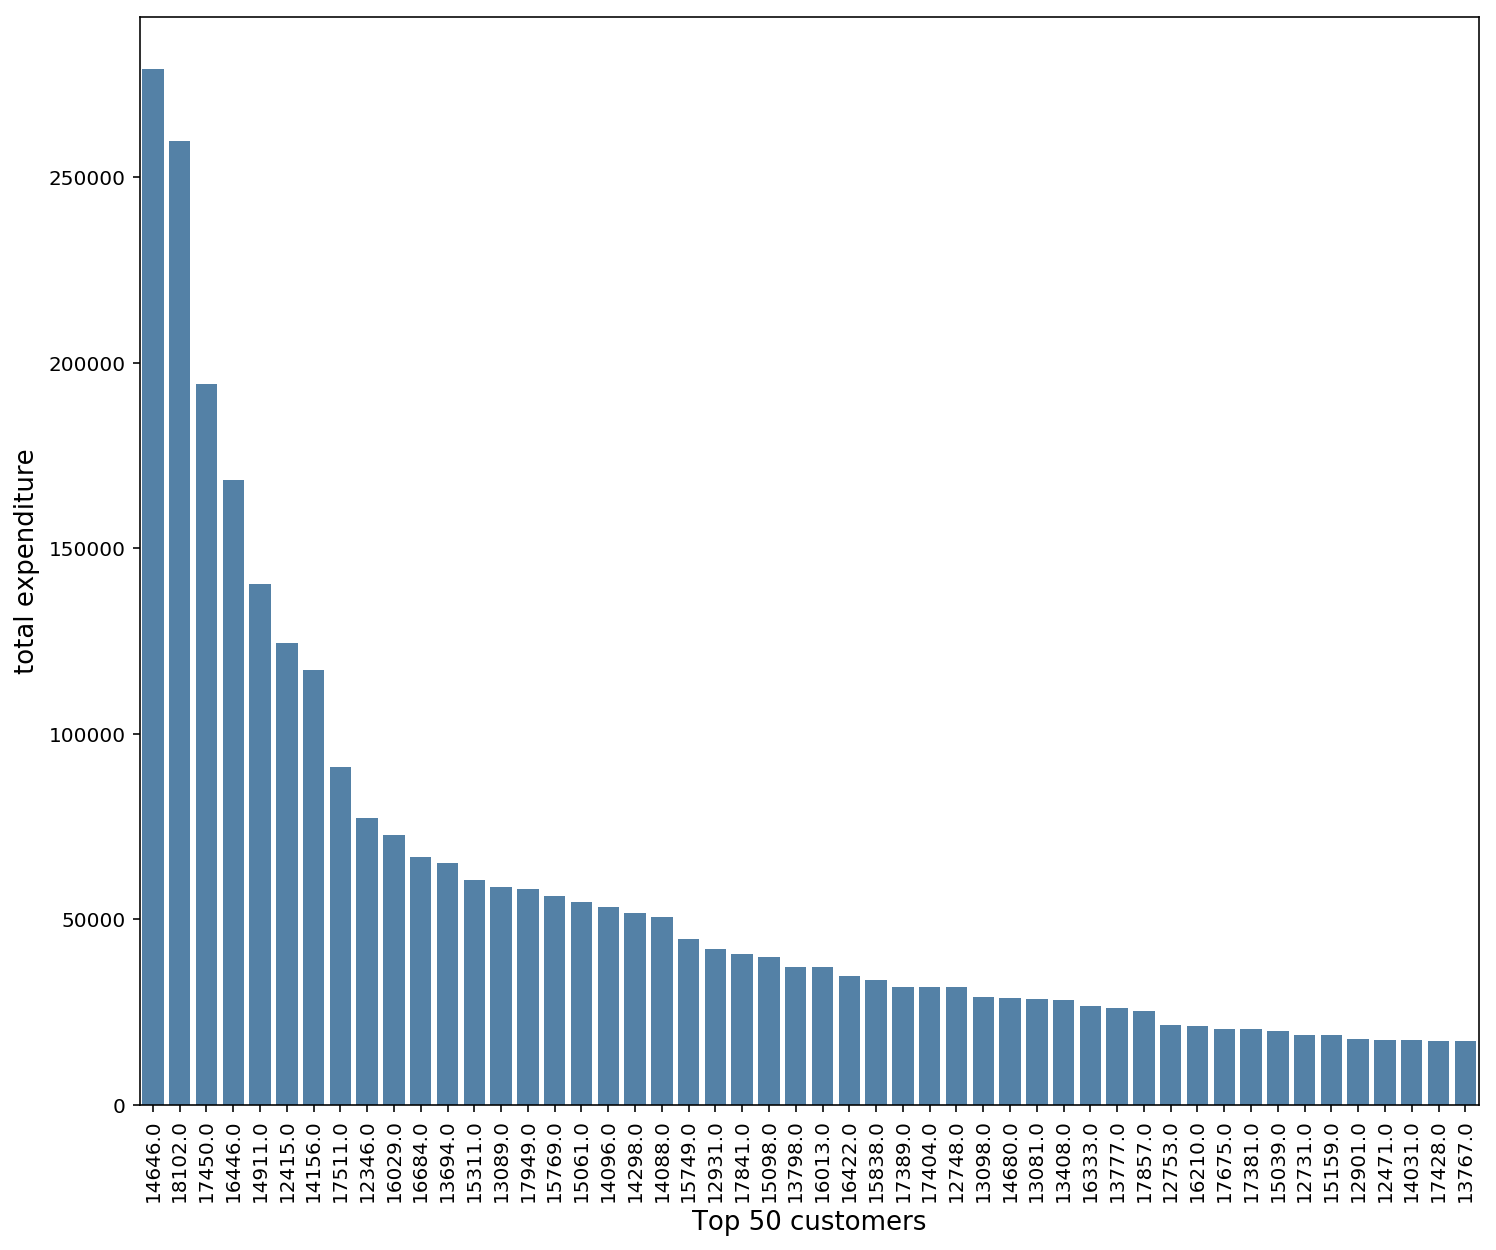

In [132]:
grouped  = data.groupby(['CustomerID']).sum()['total_spend'].sort_values(ascending=False)
grouped_top = pd.DataFrame(grouped.head(50))
grouped_top.reset_index(level=0, inplace=True)
grouped_top.sort_values('CustomerID', ascending=False)

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(x=grouped_top['CustomerID'], y=grouped_top['total_spend'],order=grouped_top['CustomerID'],color='steelblue')
plt.ylabel('total expenditure', fontsize=13)
plt.xlabel('Top 50 customers', fontsize=13)
plt.show()

### Calculate the top 50 largest baskets, in terms of total spend

In [133]:
top_50 = data[data['CustomerID'].isin(grouped_top['CustomerID'])]
top_50.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,time,total_spend
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.1,16446.0,United Kingdom,2011-12-09 09:15:00,168469.6
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.0,12346.0,United Kingdom,2011-01-18 10:01:00,77183.6
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,10/27/2011 12:26,0.2,12901.0,United Kingdom,2011-10-27 12:26:00,1008.0
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,4/18/2011 13:20,2.1,15749.0,United Kingdom,2011-04-18 13:20:00,6539.4
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,1/11/2011 12:55,2.1,15749.0,United Kingdom,2011-01-11 12:55:00,6539.4


### Locate the country of origin of the top 50 biggest spenders

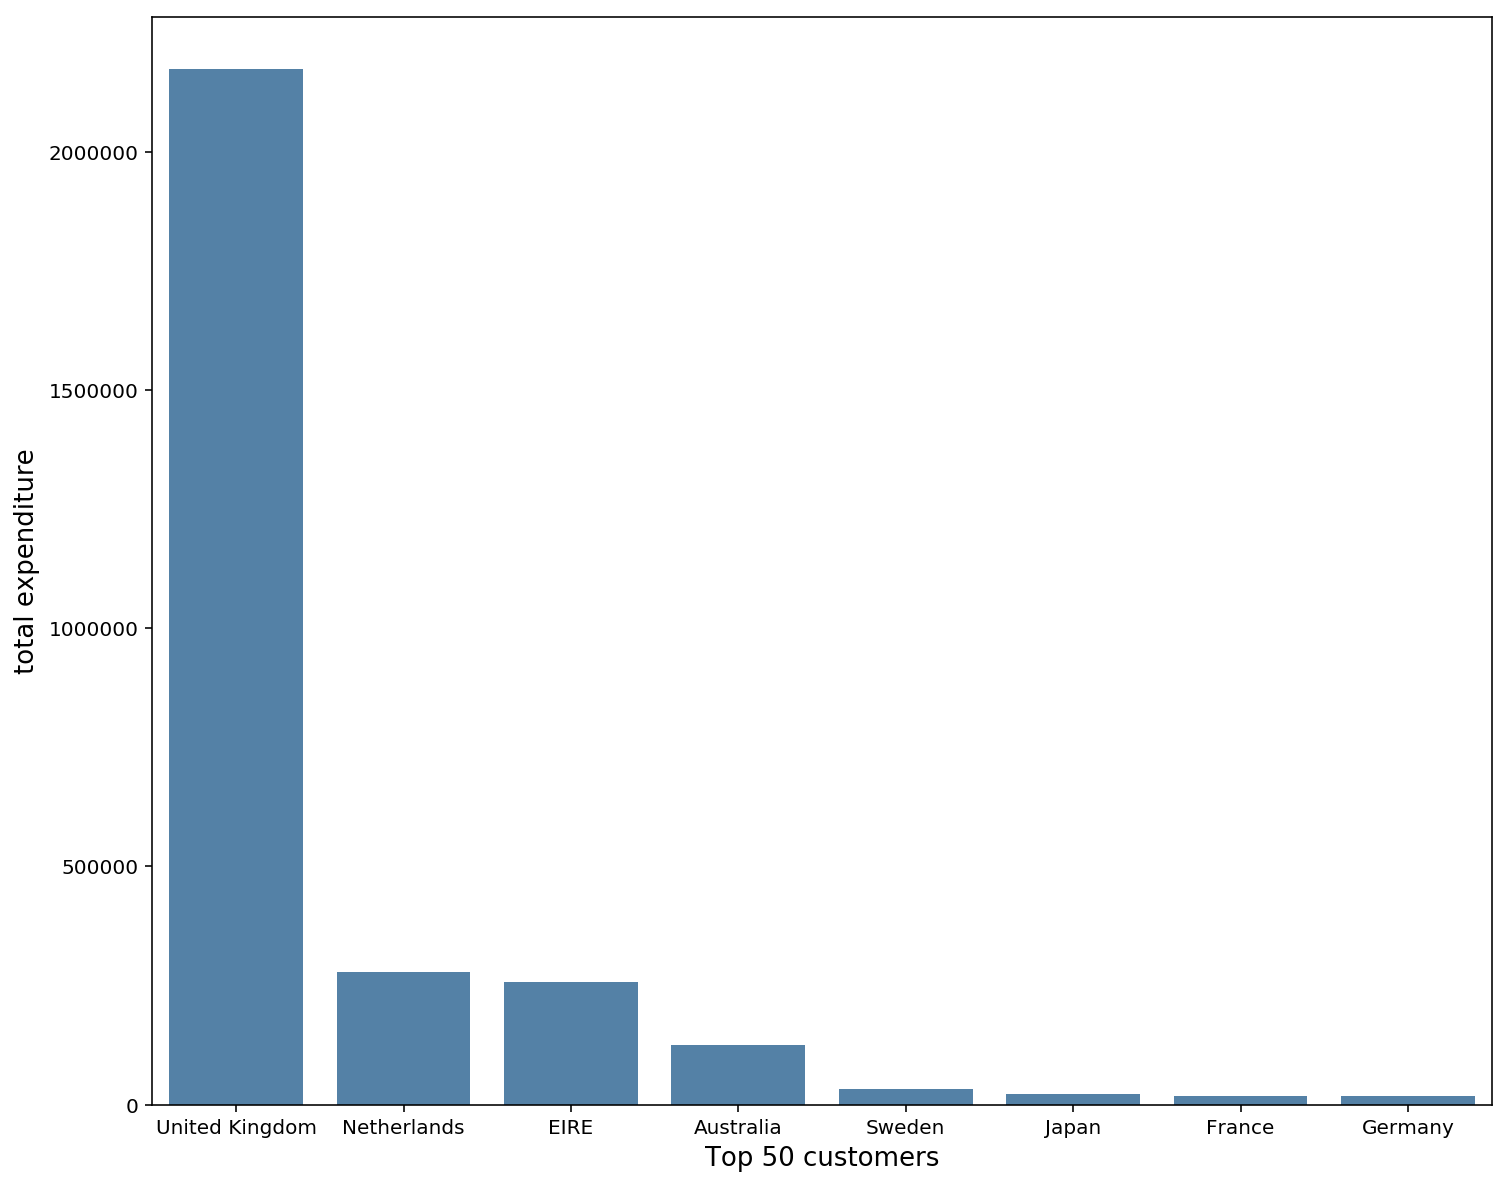

In [134]:
top50_tmp  = top_50.groupby(['Country']).sum()['total_spend'].sort_values(ascending=False)

top50_tmp = pd.DataFrame(top50_tmp)
top50_tmp.reset_index(level=0, inplace=True)
top50_tmp.sort_values('Country', ascending=False)

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='horizontal')
sns.barplot(x=top50_tmp['Country'], y=top50_tmp['total_spend'],order=top50_tmp['Country'],color='steelblue')
plt.ylabel('total expenditure', fontsize=13)
plt.xlabel('Top 50 customers', fontsize=13)
plt.show()

See the Addendum section for further use of this data for Apriori modeling.

## Classify customers based on spend

Collate all the purchases made during a single order to calculate the total order value:

In [135]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['total_spend'].sum()
basket_price = temp.rename(columns = {'total_spend':'Basket value'})

In [136]:
# top 10 baskets
basket_price.head(10)

,CustomerID,InvoiceNo,Basket value
0,12346.0,541431,77183.6
1,12347.0,537626,711.8
2,12347.0,542237,475.4
3,12347.0,549222,636.2
4,12347.0,556201,382.5
5,12347.0,562032,584.9
6,12347.0,573511,1294.3
7,12347.0,581180,224.8
8,12348.0,539318,652.8
9,12348.0,541998,187.4


/Users/scheckley/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


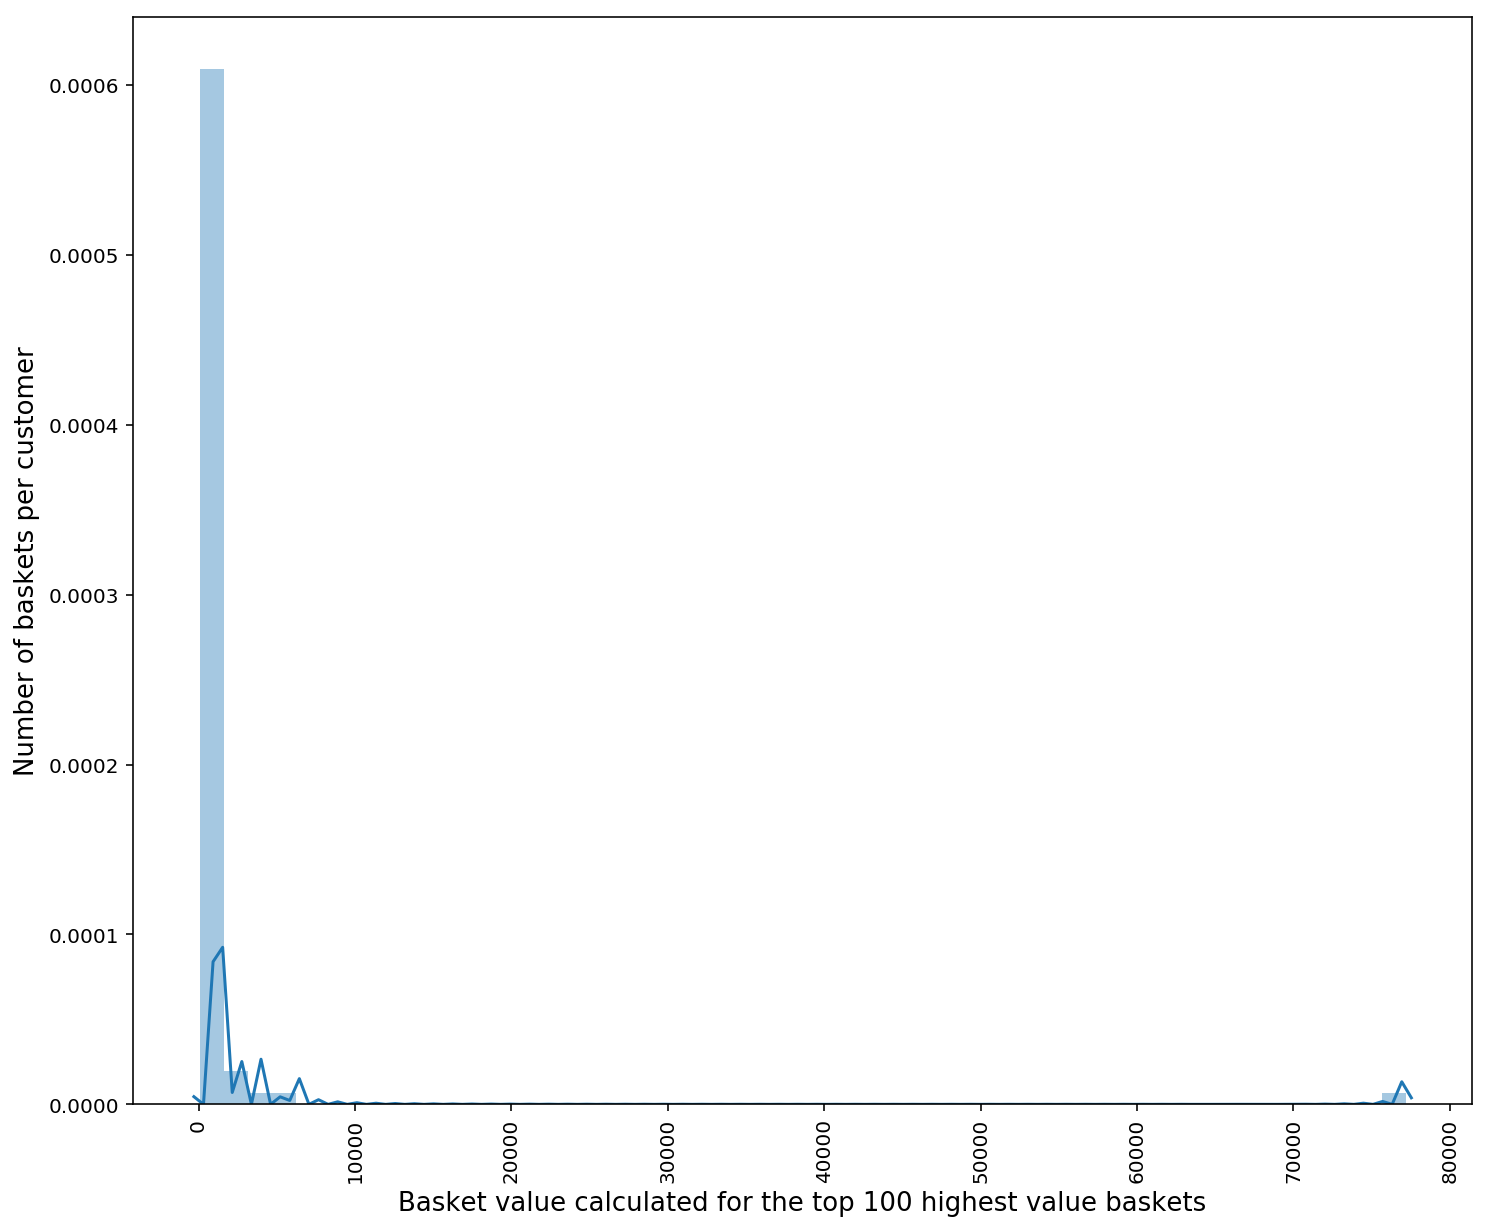

In [137]:
tmp = basket_price
tmp = pd.DataFrame(tmp)
#tmp.reset_index(level=0, inplace=True)
tmp.sort_values('Basket value', ascending=False)

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.distplot(tmp['Basket value'][:100])
plt.ylabel('Number of baskets per customer', fontsize=13)
plt.xlabel('Basket value calculated for the top 100 highest value baskets', fontsize=13)
plt.show()

The distribution of basket is somewhat bimodal.  This histogram of basket values indicates a large number of low total value baskets and a small number of individual orders totaling high value baskets. This observation can be used to bin customers into those spending small amounts, medium amounts, and high value baskets (**note** the bimodal distribution above may cause an imbalance problem for machine learning):

In [138]:
spend_label = []
for i in range(0,len(data),1):
    if data['total_spend'].iloc[i] < 5000:
        spend_label.append(1)
    elif data['total_spend'].iloc[i] >50000:
        spend_label.append(3)
    else:
        spend_label.append(2)

In [139]:
data['spend_label'] = spend_label

In [140]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,time,total_spend,spend_label
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.1,16446.0,United Kingdom,2011-12-09 09:15:00,168469.6,3
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.0,12346.0,United Kingdom,2011-01-18 10:01:00,77183.6,3
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,11/25/2011 15:57,0.0,13256.0,United Kingdom,2011-11-25 15:57:00,0.0,1
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,10/27/2011 12:26,0.2,12901.0,United Kingdom,2011-10-27 12:26:00,1008.0,1
206121,554868,22197,SMALL POPCORN HOLDER,4300,5/27/2011 10:52,0.7,13135.0,United Kingdom,2011-05-27 10:52:00,3096.0,1


In [50]:
# pickle the cleaned dataset
#pickle.dump(data, open( "clean_data.pkl", "wb" ))

## Clustering

### Group by customerID

* group by CustomerID, together with sum or number of items (quantity) and the unit price

In [141]:
data_grouped = data.groupby('CustomerID')
data_cluster=pd.DataFrame(columns=['Quantity','UnitPrice', 'total_spend', 'country', 'CustomerID'])
count=0

In [142]:
#data_grouped.head(5)

In [143]:
for k,v in (data_grouped):
    data_cluster.loc[count] = [(v['Quantity'].sum()), v['UnitPrice'].sum(), v['total_spend'].sum(), v['Country'], k]
    count+=1

# Applying K-Means Clustering Algorithm to quantity, and total spend
X = data_cluster.iloc[:, [0, 2]].values

In [144]:
data_cluster.head()

,Quantity,UnitPrice,total_spend,country,CustomerID
0,74215,1.0,77183.6,"61619 United Kingdom Name: Country, dtype: ...",12346.0
1,2458,481.2,4310.0,148290 Iceland 428974 Iceland 148303 ...,12347.0
2,2332,18.7,1437.2,70051 Finland 70052 Finland 70054 ...,12348.0
3,630,305.1,1457.5,485568 Italy 485569 Italy 485554 Ital...,12349.0
4,196,25.3,294.4,80327 Norway 80339 Norway 80338 Norwa...,12350.0


/Users/scheckley/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/scheckley/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


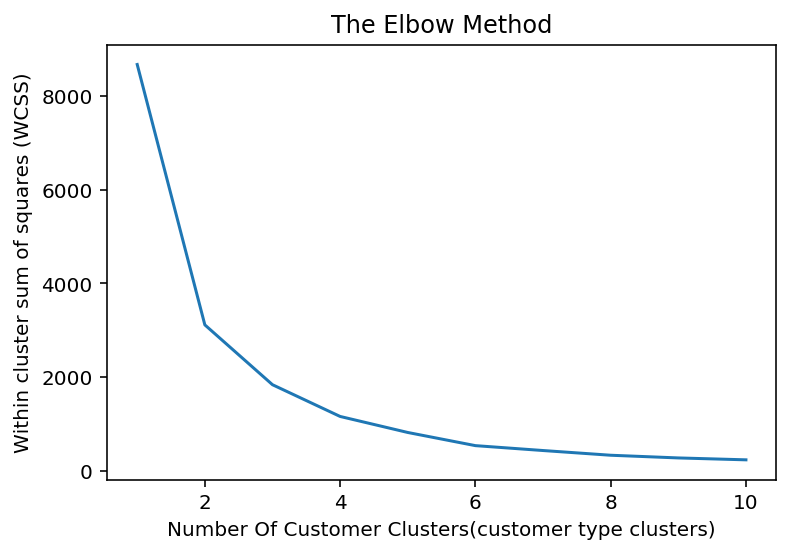

In [145]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X= sc_X.fit_transform(X)
#Using the Elbow method to find the optimum number of clusters
from sklearn.cluster import KMeans
wcss = [] #Within cluster sum of squers(Inertia)

#n_clusters is no.of clusters given by this method,
#k-means++ is an random initialization methods for centriods to avoid random intialization trap,
#max_iter is max no of iterations defined when k-means is running
#n_init is no of times k-means will run with different initial centroids

for i in range(1,11): #From 2-10 doing multiple random initializations can make a huge difference to find a better local optima
    kmeans = KMeans(n_clusters = i, init ='k-means++',max_iter=300,n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11) , wcss)
plt.title('The Elbow Method')
plt.xlabel('Number Of Customer Clusters(customer type clusters)')
plt.ylabel('Within cluster sum of squares (WCSS)')
plt.show()

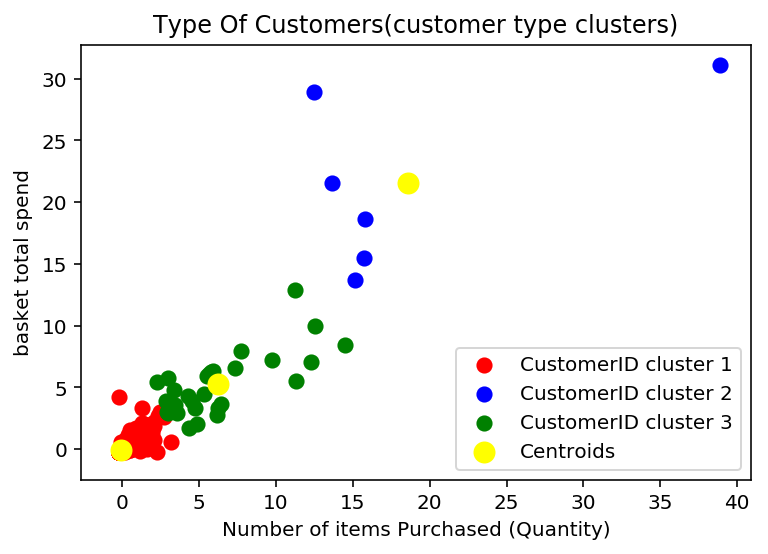

In [146]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 3, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 50, c = 'red', label = 'CustomerID cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 50, c = 'blue', label = 'CustomerID cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 50, c = 'green', label = 'CustomerID cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Type Of Customers(customer type clusters)')
plt.xlabel('Number of items Purchased (Quantity)')
plt.ylabel('basket total spend')
plt.legend()
plt.show()

Clustering appears to separate the customers based on numbers of items and total spend, which would be expected

## NLP

In [194]:
import spacy
from collections import defaultdict
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en')

In [423]:
tmp = data.Description

In [456]:
frank = []
for i in tmp[:100]:
    frank.append(i)

In [457]:
len(frank)

100

In [468]:
word_count = list()
entities = list()

pos_counts = defaultdict(Counter)
nlp.max_length = 20000000
doc = nlp(str(frank))

# count tokens, excluding stop words
for token in doc:
    for word in STOP_WORDS:
        if str(token) == str.lower(word):
            pos_counts[token.pos][token.orth] = 0
        else:
            pos_counts[token.pos][token.orth] += 1

for pos_id, counts in sorted(pos_counts.items()):
    pos = doc.vocab.strings[pos_id]
    for orth_id, count in counts.most_common():
        word_count.append([pos, count, doc.vocab.strings[orth_id],doc.ents])

for ent in doc.ents:
    entities.append([ent.text, ent.start_char, ent.end_char, ent.label_])

In [479]:
entities = pd.DataFrame(entities)
entities[3].unique()
entities.head(20)

,0,1,2,3
0,CRAFT,8,13,ORG
1,BIRDIE,23,29,PERSON
2,MEDIUM,33,39,ORG
3,TOP STORAGE JAR',48,64,ORG
4,ASSTD DESIGN,67,79,FAC
5,PAPER STICKERS',83,98,ORG
6,WORLD WAR 2,101,112,EVENT
7,DESIGNS,127,134,PERSON
8,EMPIRE DESIGN ROSETTE',162,184,ORG
9,BALM,197,201,PERSON


Not useful

In [477]:
word_count = pd.DataFrame(word_count)
word_count = word_count[~word_count[0].isin(['PUNCT','SPACE','ADP','NUM','DET','ADJ'])]
word_count.sort_values([1], ascending=False,inplace=True)
word_count.head()

,0,1,2,3
15,NOUN,4270,PACK,"((CRAFT), (BIRDIE), (MEDIUM), (TOP, STORAGE, J..."
68,PROPN,3355,ASSTD,"((CRAFT), (BIRDIE), (MEDIUM), (TOP, STORAGE, J..."
16,NOUN,3050,GLIDERS,"((CRAFT), (BIRDIE), (MEDIUM), (TOP, STORAGE, J..."
17,NOUN,3050,DESIGNS,"((CRAFT), (BIRDIE), (MEDIUM), (TOP, STORAGE, J..."
70,PROPN,3050,WAR,"((CRAFT), (BIRDIE), (MEDIUM), (TOP, STORAGE, J..."


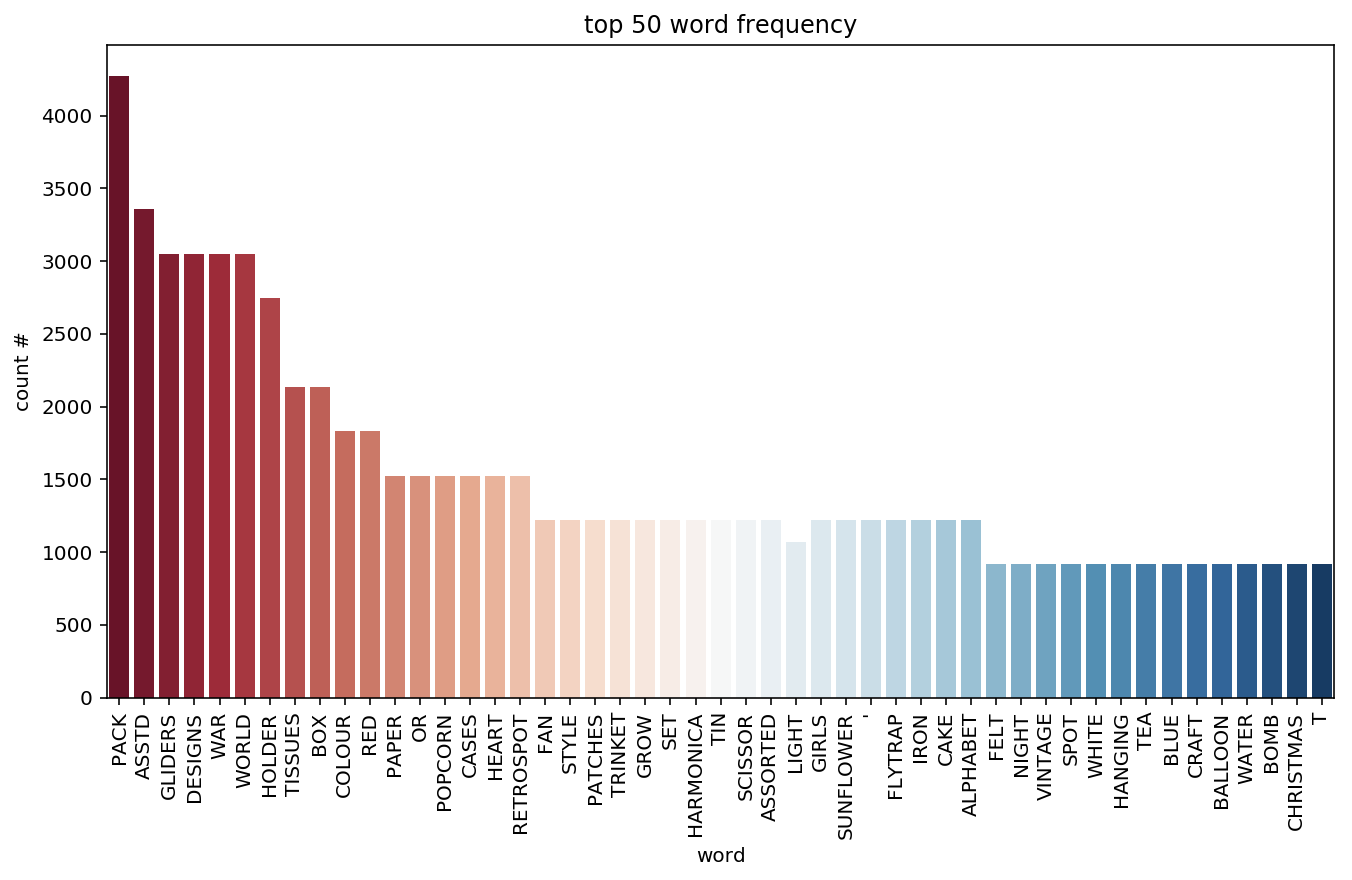

In [478]:
# plot top (n) word occurrances
f, ax = plt.subplots(figsize=(11, 6))

tmp = word_count.head(50)

g=sns.barplot(x=tmp[2],y=tmp[1],data=tmp,palette="RdBu", ci=None)
g.set(xlabel='word', ylabel='count #',title="top 50 word frequency");
for item in g.get_xticklabels():
    item.set_rotation(90)

NLP isn't providing a huge amount of information to categorise items at this time...

## Task 4 - Modelling

### Machine learning data preparation

In [3]:
data = pickle.load(open( "clean_data.pkl", "rb" ))

A cursory examination of correlation to identify potentially problematic variables from the model training dataset.

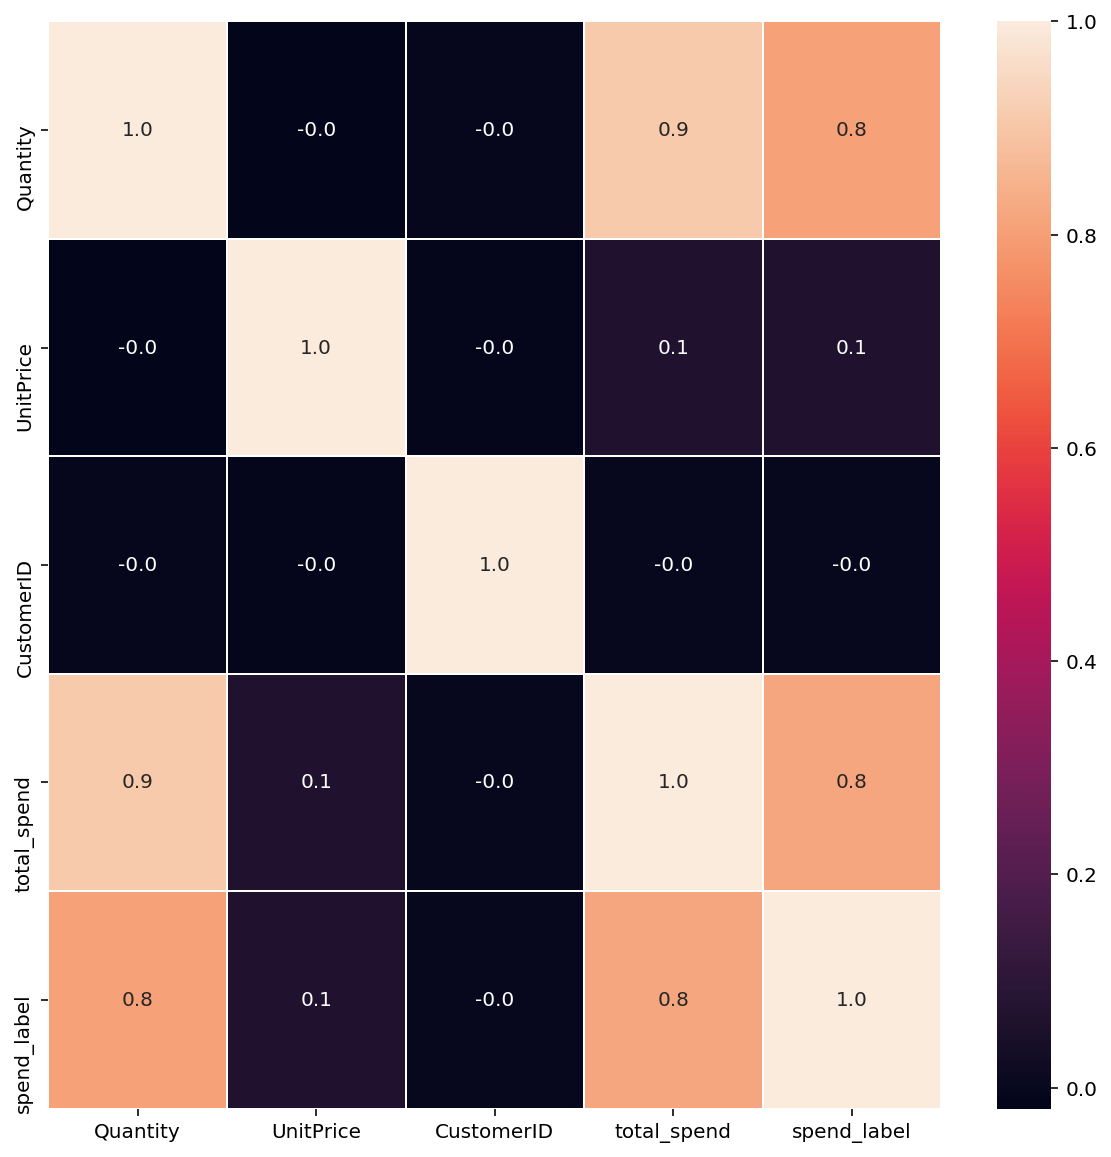

In [147]:
# heat map to look for correlation
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);

Unsurprisingly, total spend correlates with quantity and the spend_label. Potentially, quantity or total spend may have to be removed for training.

/Users/scheckley/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


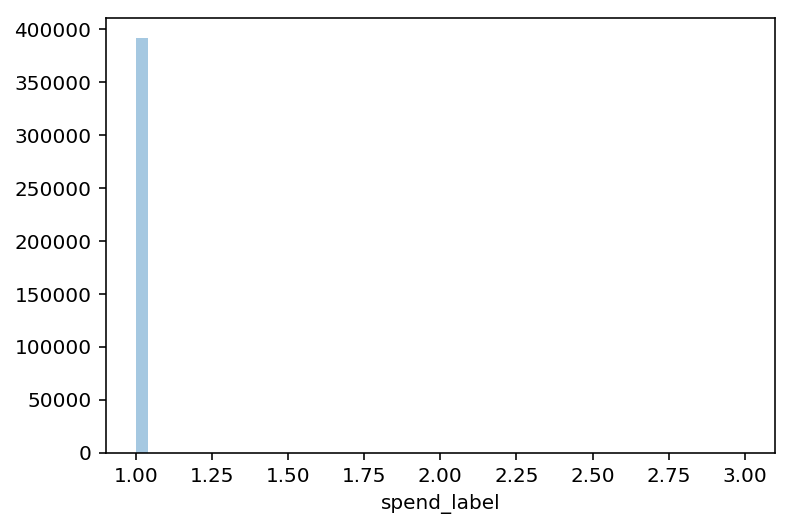

In [148]:
sns.distplot(data['spend_label'],kde = False)
plt.show()

This data is very imbalanced. For the purposes of this investigation the lower value baskets will be used for prediction.

Below I will identify a range suitable for binning:

In [6]:
data2 = data[(data['total_spend'] >0) & (data['total_spend'] < 100)]

/Users/scheckley/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


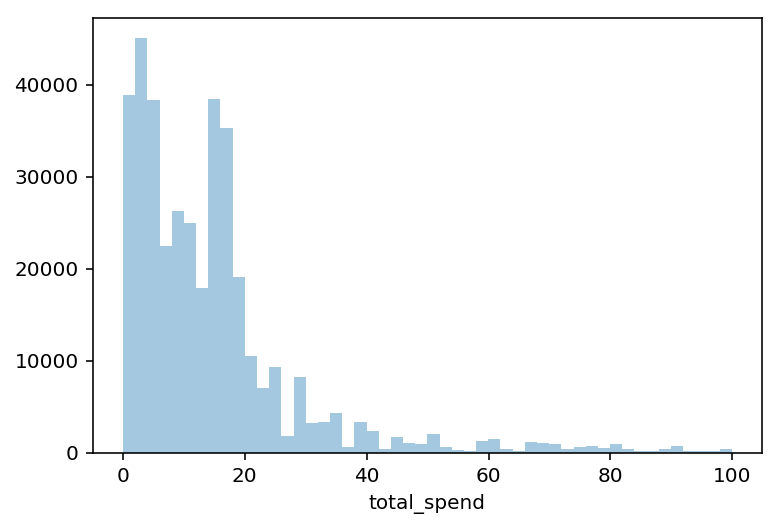

In [222]:
sns.distplot(data2['total_spend'],kde = False)
plt.show()

In [7]:
spend_label = []
for i in range(0,len(data2),1):
    if data2['total_spend'].iloc[i] < 10:
        spend_label.append(0)
    elif data2['total_spend'].iloc[i] >40:
        spend_label.append(2)
    else:
        spend_label.append(1)

Numerical labels represent 0 - low value baskets, 1 - medium value baskets, 3 - higher value baskets.

In [8]:
data2['spend_label'] = spend_label

/Users/scheckley/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [225]:
data2.shape # there is still a reasonably large sized data set to work with

(379870, 11)

/Users/scheckley/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


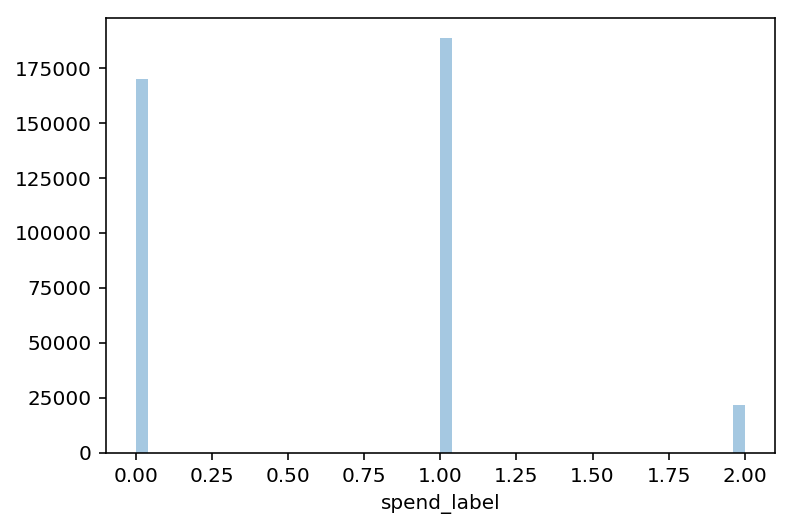

In [226]:
sns.distplot(data2['spend_label'],kde = False)
plt.show()

The data is still unbalanced in terms of representation from high value baskets, but more balanced than the full dataset

### Create dummy variables from the string columns

In [9]:
# encode the description label
cols_to_transform = ['Description']
type_hash = pd.get_dummies(data=data2['Description'])
type_hash2 = pd.get_dummies(data=data2['Country'])

In [10]:
learning_data = pd.concat([data2, type_hash, type_hash2], axis=1)

In [11]:
# drop the columns that have been now been replaced and that are not required
droplist = ['Quantity','StockCode','InvoiceDate','InvoiceNo','UnitPrice','Description','time','Country','CustomerID']
learning_data = learning_data.drop(droplist, axis=1)

In [12]:
learning_data = learning_data.reset_index(drop=True)

In [13]:
xdata = learning_data.copy()
del xdata['spend_label']
ydata = learning_data['spend_label']

In [14]:
normalized_xdata = preprocessing.normalize(xdata)

In [ ]:
scaler = StandardScaler()
scaler.fit(normalized_xdata[:100000])

pca = decomposition.PCA(n_components=5)
pc = pca.fit_transform(normalized_xdata[:100000]) #PCA is being performed on the 1st 100000 data points due to limited compute resource

pc_df = pd.DataFrame(data = pc , 
        columns = ['PC1', 'PC2','PC3','PC4', 'PC5'])
pc_df.head()

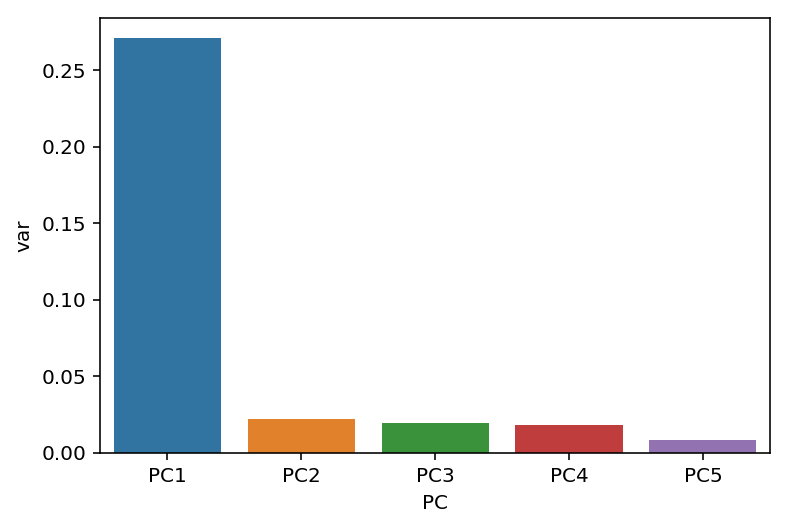

In [234]:
# plot the variance
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':['PC1','PC2','PC3','PC4', 'PC5']})
sns.barplot(x='PC',y="var", 
           data=df);

In [235]:
scaler = StandardScaler()
scaler.fit(xdata[:100000])
X=scaler.transform(xdata[:100000])

pca = PCA(n_components=2)
pca.fit(X,ydata)
x_new = pca.transform(X) 

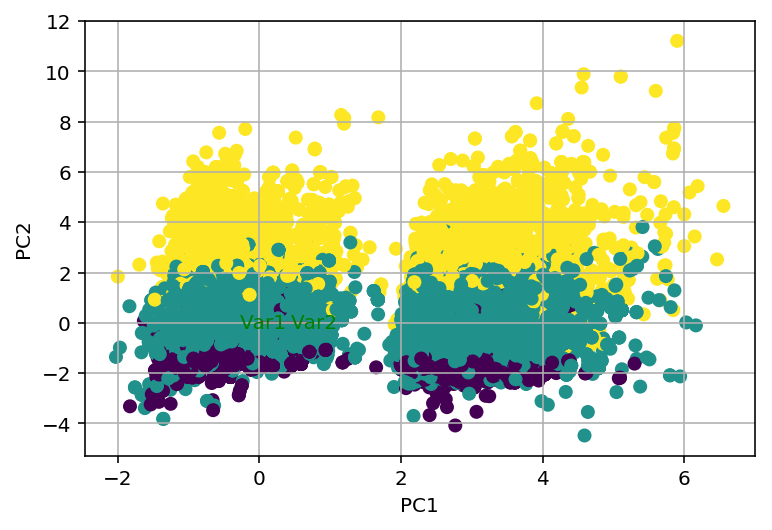

In [236]:
def pca_plot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]

    plt.scatter(xs ,ys, c =ydata[:100000]) #without scaling
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. 
pca_plot(x_new[:,0:2], pca. components_) 
plt.show()

* From the PCA analysis of the dataset, the majority of variance in the model is in the 1st principle component. It is of no great surprise that potentially, total spend is sufficient to predict the basket size label. From visualisation of the principle components, the labels are well separated/clustered, facilitating  machine learning. The bimodal appearance of the data requires further investigation.

### Country as label

In [83]:
scaler = StandardScaler()
scaler.fit(xdata[:100000])
X=scaler.transform(xdata[:100000])

pca = PCA(n_components=2)
pca.fit(X,ydata2)
x_new = pca.transform(X) 

In [ ]:
def pca_plot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]

    plt.scatter(xs ,ys, c =ydata[:100000]) #without scaling
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. 
pca_plot(x_new[:,0:2], pca. components_) 
plt.show()

### Data preparation for training country of origin

In [121]:
# encode the description label
cols_to_transform = ['Description']
type_hash = pd.get_dummies(data=data2['Description'])

In [122]:
learning_data2 = pd.concat([data2, type_hash], axis=1)

In [123]:
learning_data2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,time,total_spend,spend_label,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,15 PINK FLUFFY CHICKS IN BOX,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PC CUTLERY SET PANTRY DESIGN,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,2 DAISIES HAIR COMB,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,2 PICTURE BOOK EGGS EASTER DUCKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 BIRDS CANVAS SCREEN,3 BLACK CATS W HEARTS BLANK CARD,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 GARDENIA MORRIS BOXED CANDLES,3 HEARTS HANGING DECORATION RUSTIC,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 PINK HEN+CHICKS IN BASKET,3 RAFFIA RIBBONS 50'S CHRISTMAS,...,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP SUMMER ROSE DESIGN,WRAP VINTAGE LEAF DESIGN,WRAP VINTAGE PETALS DESIGN,WRAP WEDDING DAY,"WRAP, BILLBOARD FONTS DESIGN","WRAP, CAROUSEL",YELLOW BREAKFAST CUP AND SAUCER,YELLOW COAT RACK PARIS FASHION,YELLOW DRAGONFLY HELICOPTER,YELLOW EASTER EGG HUNT START POST,YELLOW FELT HANGING HEART W FLOWER,YELLOW FLOWERS FELT HANDBAG KIT,YELLOW GIANT GARDEN THERMOMETER,YELLOW METAL CHICKEN HEART,YELLOW PINK FLOWER DESIGN BIG BOWL,YELLOW POT PLANT CANDLE,YELLOW SHARK HELICOPTER,YELLOW/BLUE RETRO RADIO,YELLOW/ORANGE FLOWER DESIGN PLATE,YELLOW/PINK FLOWER DESIGN BIG MUG,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,YULETIDE IMAGES S/6 PAPER BOXES,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FINISH 15CM PLANTER POTS,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC HEARTS PLANT POT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC PLANT POT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
221722,556267,16216,LETTER SHAPE PENCIL SHARPENER,1600,6/9/2011 19:33,0.1,13694.0,United Kingdom,2011-06-09 19:33:00,96.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
221744,556267,15034,PAPER POCKET TRAVELING FAN,1200,6/9/2011 19:33,0.1,13694.0,United Kingdom,2011-06-09 19:33:00,84.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
371176,569214,15034,PAPER POCKET TRAVELING FAN,1200,10/2/2011 12:22,0.1,14533.0,United Kingdom,2011-10-02 12:22:00,84.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
276441,561047,16045,POPART WOODEN PENCILS ASST,900,7/24/2011 12:46,0.0,16948.0,United Kingdom,2011-07-24 12:46:00,36.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
513189,579538,20668,DISCO BALL CHRISTMAS DECORATION,864,1

In [125]:
# drop the columns that have been now been replaced and that are not required
droplist = ['Quantity','StockCode','InvoiceDate','InvoiceNo','UnitPrice','Description','time','spend_label','CustomerID']
learning_data2 = learning_data2.drop(droplist, axis=1)

In [126]:
learning_data2 = learning_data2.reset_index(drop=True)

In [127]:
xdata2 = learning_data2.copy()
del xdata2['Country']
ydata2 = learning_data2['Country']

In [128]:
# convert ydata2 to integer
ydata2 = ydata2.astype('category')

In [ ]:
normalized_xdata2 = preprocessing.normalize(xdata2)

### Machine learning - predicting customer spend

In [15]:
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,accuracy_score, f1_score
from sklearn.model_selection import  cross_val_score
from sklearn.externals import joblib #for saving the trained model

For the purposes of this work I will select a 70/30 split - 70% training data and 30% test data. This approach does not use a validation set however it provides a large dataset for training and testing. Cross validation of the training data set will also be used during model training.

In [16]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(normalized_xdata,ydata,test_size = 0.3, random_state = 8418) #70/30 training/test split - standard

Some helper functions for visualizing model output

In [17]:
import itertools

# confusion matrix plotting function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Naive Bayes

Naive bayes was chosen to build the 1st iteration of the model because it is a fast algorithm and requires no hyperparameters. This method will provide an indication of whether or not a model can be built using this dataset without using more computationally expensive methods.

In [25]:
from sklearn.naive_bayes import GaussianNB #choose model class - done
nb_model = GaussianNB() #instantiate the model - done (GaussianNB has no hyperparameters)
nb_model.fit(xtrain, ytrain) #fit the model to the data

In [167]:
# Use the trained model to predict on the test data
predictions = list(nb_model.predict(xtest))

accuracy = accuracy_score(ytest, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Recall:', recall_score(ytest, predictions,average="micro")*100,"%")
print('Precision:', precision_score(ytest, predictions,average="micro")*100,"%")

Accuracy: 63.22%
Recall: 63.218118479128826 %
Precision: 63.218118479128826 %


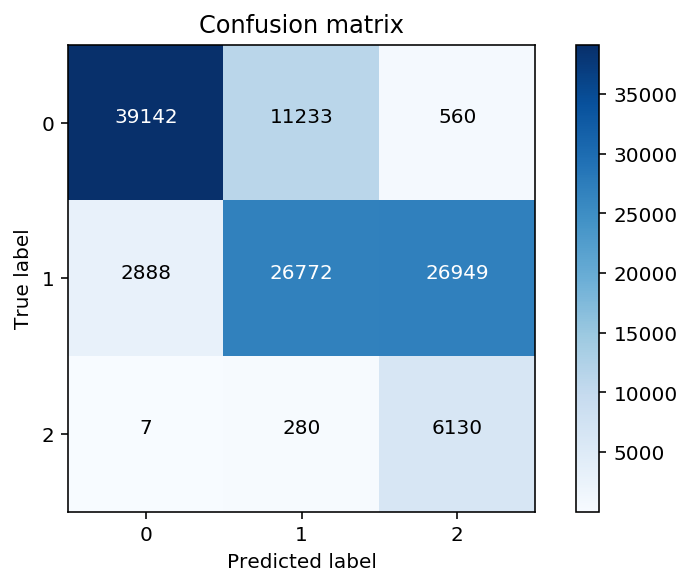

In [287]:
dat = confusion_matrix(ytest, predictions)

plot_confusion_matrix(
    dat, classes=[0,1,2], title='Confusion matrix')
plt.show()

In [250]:
#joblib.dump(nb_model, 'nb_model.pkl')

['nb_model.pkl']

In [5]:
nb_model = joblib.load('nb_model.pkl')

In [18]:
xval_score = cross_val_score(nb_model, xtrain, ytrain, cv=5, n_jobs=-1).mean() #5-fold cross validation

In [19]:
xval_score

0.6334911815758699

The naive bayes model is approximatley 63% accurate in predicting how likely a customer is to be purchasing a low, medium, or high value basket. The model is biased toward the small basket size, presumably due to bias in the training set.

### LightGBM

Microsoft's LightGBM algorithm was selected to build a 2nd model. This algorithm is relatively new and is designed to be faster and more accurate than XGBoost [1,2]

In [38]:
import lightgbm as lgb 

In [265]:
train_data=lgb.Dataset(xtrain,label=ytrain)

Due to limited time and compute resource I will use 5-fold cross validation when training the LightGBM model.  

In [ ]:
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':3,
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'max_depth': 7,
    'num_leaves': 17,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 17}

lgb_cv = lgb.cv(params, train_data, num_boost_round=10000, nfold=5, shuffle=True, stratified=True, verbose_eval=20, early_stopping_rounds=100)

nround = lgb_cv['multi_logloss-mean'].index(np.min(lgb_cv['multi_logloss-mean']))

In [267]:
model = lgb.train(params, train_data, num_boost_round=nround)

In [169]:
#predicting on test set
ypred=model.predict(xtest)

In [170]:
predictions = []

for x in ypred:
    predictions.append(np.argmax(x))

In [171]:
accuracy = accuracy_score(ytest, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Recall:', recall_score(ytest, predictions,average="micro")*100,"%")
print('Precision:', precision_score(ytest, predictions,average="micro")*100,"%")

Accuracy: 99.99%
Recall: 99.99122506822509 %
Precision: 99.99122506822509 %


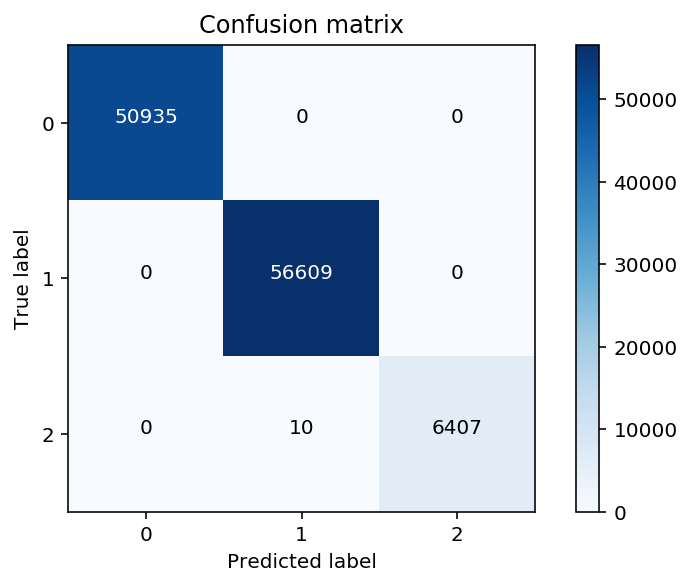

In [271]:
dat = confusion_matrix(ytest, predictions)

plot_confusion_matrix(
    dat, classes=[0,1,2], title='Confusion matrix')
plt.show()

In [272]:
#joblib.dump(model, 'lgbm_model.pkl')

['lgbm_model.pkl']

The LightGBM model is 99% accurate at predicting how likely a customer is to be purchasing a low, medium, or high value basket. This algorithm is superior to Naive bayes but requires significantly higher compute resource.

### Machine learning - predicting country of origin

In [136]:
xtrain, xtest, ytrain, ytest = train_test_split(normalized_xdata2,ydata2,test_size = 0.3, random_state = 8418) #70/30 training/test split - standard

### Naive Bayes

In [26]:
nb_model2 = GaussianNB() #instantiate the model - done (GaussianNB has no hyperparameters)
nb_model2.fit(xtrain, ytrain) #fit the model to the data

GaussianNB(priors=None)

In [139]:
# Use the trained model to predict on the test data
predictions = list(nb_model2.predict(xtest))

Accuracy: 6.69%
Recall: 0.06690885478365406
Precision: 0.06690885478365406


In [141]:
accuracy = accuracy_score(ytest, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print('Recall:', recall_score(ytest, predictions,average="micro")*100)
print('Precision:', precision_score(ytest, predictions,average="micro")*100)

Accuracy: 6.69%
Recall: 6.690885478365407
Precision: 6.690885478365407


In [138]:
#joblib.dump(nb_model2, 'nb_model2.pkl')

['nb_model2.pkl']

This is a very poor model using Naive Bayes and further analysis using this method and LightGBM should be tried instead.

### LightGBM

In [148]:
# convert string label to float & make new sets for LightGBM
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
ydata_float = lb.fit_transform(ydata2)

xtrain, xtest, ytrain, ytest = train_test_split(normalized_xdata2,ydata_float,test_size = 0.3, random_state = 8418) #70/30 training/test split - standard

In [87]:
train_data=lgb.Dataset(xtrain,label=ytrain)

In [ ]:
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':37,
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'max_depth': 7,
    'num_leaves': 17,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 17}

lgb_cv = lgb.cv(params, train_data, num_boost_round=10000, nfold=5, shuffle=True, stratified=True, verbose_eval=20, early_stopping_rounds=100)

nround = lgb_cv['multi_logloss-mean'].index(np.min(lgb_cv['multi_logloss-mean']))

In [89]:
lgbm_model2 = lgb.train(params, train_data, num_boost_round=nround)

In [149]:
#predicting on test set
ypred=lgbm_model2.predict(xtest)

In [150]:
predictions = []

for x in ypred:
    predictions.append(np.argmax(x))

In [151]:
accuracy = accuracy_score(ytest, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Recall:', recall_score(ytest, predictions,average="micro")*100,"%")
print('Precision:', precision_score(ytest, predictions,average="micro")*100,"%")

Accuracy: 89.56%
Recall: 89.56046366739498 %
Precision: 89.56046366739498 %


In [94]:
#joblib.dump(lgbm_model2, 'lbgm_model2.pkl')

['lbgm_model2.pkl']

The LightGBM model significantly out-performs Naive bayes, producing a model for predicting country of origin of customers wtih approximately 90% accuracy.

# RFM Analysis

* https://joaocorreia.io/blog/rfm-analysis-increase-sales-by-segmenting-your-customers.html
* https://github.com/joaolcorreia/RFM-analysis

 python2 RFM-analysis.py -i data_clean.csv -o rfm-segments.csv -d "2011-12-09"

In [64]:
rfm_data = pd.read_csv('rfm-segments.csv')

In [66]:
rfm_data.head()

,customer,frequency,recency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
0,12346.0,1,325,77183.6,4,4,1,441
1,12347.0,182,2,4310.0,1,1,1,111
2,12348.0,27,75,1437.2,3,3,2,332
3,12349.0,72,18,1457.5,2,2,2,222
4,12350.0,16,310,294.4,4,4,4,444


---

## Addendum - Apriori modeling proof of concept

Apriori modeling requires no feature engineering, machine learning, or significant compute time and is an alternative approach to machine learning for this form of exercise. [4]

Modeling will be applied to the top customer identified in the earlier data analysis as a proof of concept recommender system.

In [691]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

### Generate a basket for the top spending customer identified from the dataset

As an example, the customerid corresponding with the highest spend was identified during the data analysis and the customer's basket extracted for further analysis.  This method could optimize the prediction of stock levels to facilitate customers who make large, bulk orders or order expensive or difficult to source items ahead of schedule.

In [692]:
basket = top_basket.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

In [693]:
basket.head()

Description,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PINK HEN+CHICKS IN BASKET,12 RED ROSE PEG PLACE SETTINGS,16 PIECE CUTLERY SET PANTRY DESIGN,2 PICTURE BOOK EGGS EASTER BUNNY,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 PINK HEN+CHICKS IN BASKET,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN GREEN AND CREAM,3 TIER CAKE TIN RED AND CREAM,3 TRADITIONAl BISCUIT CUTTERS SET,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,3D CHRISTMAS STAMPS STICKERS,4 BLUE DINNER CANDLES SILVER FLOCK,4 BURGUNDY WINE DINNER CANDLES,4 IVORY DINNER CANDLES SILVER FLOCK,4 PINK DINNER CANDLE SILVER FLOCK,4 PINK FLOCK CHRISTMAS BALLS,4 PURPLE FLOCK DINNER CANDLES,4 SKY BLUE DINNER CANDLES,5 HOOK HANGER RED MAGIC TOADSTOOL,50CM METAL STRING WITH 7 CLIPS,6 CHOCOLATE LOVE HEART T-LIGHTS,6 EGG HOUSE PAINTED WOOD,6 RIBBONS RUSTIC CHARM,6 RIBBONS SHIMMERING PINKS,6 ROCKET BALLOONS,60 TEATIME FAIRY CAKE CASES,72 SWEETHEART FAIRY CAKE CASES,75 GREEN FAIRY CAKE CASES,ABC TREASURE BOOK BOX,"ACRYLIC JEWEL ICICLE, BLUE","ACRYLIC JEWEL SNOWFLAKE, PINK",ADULT APRON APPLE DELIGHT,...,WOOD STAMP SET BEST WISHES,WOOD STAMP SET FLOWERS,WOOD STAMP SET HAPPY BIRTHDAY,WOOD STAMP SET THANK YOU,WOOD STOCKING CHRISTMAS SCANDISPOT,WOODEN ADVENT CALENDAR CREAM,WOODEN ADVENT CALENDAR RED,WOODEN BOX OF DOMINOES,WOODEN FRAME ANTIQUE WHITE,WOODEN HAPPY BIRTHDAY GARLAND,WOODEN HEART CHRISTMAS SCANDINAVIAN,WOODEN PICTURE FRAME WHITE FINISH,WOODEN REGATTA BUNTING,WOODEN SCHOOL COLOURING SET,WOODEN STAR CHRISTMAS SCANDINAVIAN,WOODEN TREE CHRISTMAS SCANDINAVIAN,WOODEN UNION JACK BUNTING,WOODLAND CHARLOTTE BAG,WOODLAND DESIGN COTTON TOTE BAG,WOODLAND MINI BACKPACK,WOVEN ROSE GARDEN CUSHION COVER,WOVEN SUNSET CUSHION COVER,WRAP 50'S CHRISTMAS,WRAP ALPHABET DESIGN,WRAP CHRISTMAS VILLAGE,WRAP COWBOYS,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP MAGIC FOREST,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP SUKI AND FRIENDS,WRAP VINTAGE LEAF DESIGN,WRAP VINTAGE PETALS DESIGN,YELLOW EASTER EGG HUNT START POST,ZINC HEART T-LIGHT HOLDER,ZINC FINISH 15CM PLANTER POTS,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [694]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

Frequent items sets where calculated using the apriori algorithm, with a minimum support of 20%, that is 20% probability that one item will be purchased with another item in the same order.

In [695]:
frequent_itemsets = apriori(basket_sets, min_support=0.2, use_colnames=True) #70% support required for an association

Association rules were generated using the "lift" metric [4]; the ratio of the observed support that would be expected if the antecedent and consequent were independent.

In [696]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(BLUE/CREAM STRIPE CUSHION COVER),(CHILLI LIGHTS),0.4,0.5,0.2,0.5,1.0,0.0,1.0
1,(CHILLI LIGHTS),(BLUE/CREAM STRIPE CUSHION COVER),0.5,0.4,0.2,0.4,1.0,0.0,1.0
2,(GUMBALL COAT RACK),(BLUE/CREAM STRIPE CUSHION COVER),0.4,0.4,0.2,0.6,1.5,0.1,1.4
3,(BLUE/CREAM STRIPE CUSHION COVER),(GUMBALL COAT RACK),0.4,0.4,0.2,0.5,1.5,0.1,1.4
4,(PACK OF 60 DINOSAUR CAKE CASES),(BLUE/CREAM STRIPE CUSHION COVER),0.4,0.4,0.2,0.5,1.4,0.1,1.3
5,(BLUE/CREAM STRIPE CUSHION COVER),(PACK OF 60 DINOSAUR CAKE CASES),0.4,0.4,0.2,0.5,1.4,0.1,1.3
6,(CHARLOTTE BAG SUKI DESIGN),(CHILLI LIGHTS),0.4,0.5,0.2,0.6,1.1,0.0,1.2
7,(CHILLI LIGHTS),(CHARLOTTE BAG SUKI DESIGN),0.5,0.4,0.2,0.4,1.1,0.0,1.1
8,(PACK OF 60 DINOSAUR CAKE CASES),(CHILLI LIGHTS),0.4,0.5,0.2,0.6,1.2,0.0,1.3
9,(CHILLI LIGHTS),(PACK OF 60 DINOSAUR CAKE CASES),0.5,0.4,0.2,0.5,1.2,0.0,1.2


### Generate a basket for a country

Per country trends could be identified which could assist with business metrics such as optimum location of distribution centres, load balancing of servers, and also placement of items within a warehouse to optimise item picking.

In [726]:
basket = (data[data['Country'] == "Switzerland"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))

def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

In [731]:
frequent_itemsets = apriori(basket_sets, min_support=0.2, use_colnames=True) #70% support required for an association

In [732]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN SPACEBOY),0.2,0.4,0.2,0.9,2.4,0.1,6.8
1,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN CIRCUS PARADE),0.4,0.2,0.2,0.6,2.4,0.1,1.7
2,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),0.3,0.4,0.3,0.8,2.1,0.1,3.3
3,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.4,0.3,0.3,0.7,2.1,0.1,2.4


In conclusion, Apriori modeling of stock levels based on statistically correlated items could improve the performance and efficiency of sales compared with stocking items using emperical evidence from historical sales of similar types of items.

---

# References

1. https://towardsdatascience.com/introduction-to-naive-bayes-classification-4cffabb1ae54

2. https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/

3. https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db

4. https://www.wikiwand.com/en/Association_rule_learning#/Lift

5. https://github.com/hyperopt/hyperopt

---